In [1]:
import numpy as np
import scipy.io as sio
import sys
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from matplotlib import pyplot as plt

from pathlib import Path
import os
import random
import math
import innvestigate
import numpy as np
import matplotlib.ticker as mticker

import h5py
#


In [2]:
tf.compat.v1.disable_eager_execution()
path_to_folder = 'C:/Users/dominika/vpnet/tensorflow'
path_to_model = 'C:/Users/dominika/vpnet/trained_models/synhermite_full_model.h5'
sys.path.insert(0, path_to_folder)
from VPLayer import VPLayer

model = tf.keras.models.load_model(path_to_model, custom_objects={'VPLayer': VPLayer})

c:\Users\dominika\anaconda3\envs\innvestigate\Lib\site-packages\keras\src\backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [3]:
#synhermite test data

with h5py.File('C:/Users/dominika/vpnet/tensorflow/synhermite_test_data.h5', 'r') as hf:
    test_x = hf['test_x'][:]
    test_y = hf['test_y'][:]

"""
#test_train_ecg
with h5py.File('C:/Users/dominika/vpnet/tensorflow/ecg_test_data.h5', 'r') as hf:
    test_x = hf['test_x'][:]
    test_y = hf['test_y'][:]
"""

"\n#test_train_ecg\nwith h5py.File('C:/Users/dominika/vpnet/tensorflow/ecg_test_data.h5', 'r') as hf:\n    test_x = hf['test_x'][:]\n    test_y = hf['test_y'][:]\n"

In [4]:
test_y.shape[1]
possible_classes=[i for i in range(0,test_y.shape[1])]
possible_classes

[0, 1, 2]

In [4]:
predictions = model.predict(test_x, verbose = 2)
model_wo_softmax = innvestigate.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer(
    "lrp.epsilon", model, disable_model_checks=True,neuron_selection_mode="index", **{"epsilon": 1}
)

a = analyzer.analyze(test_x, neuron_selection=1)
print(a.shape)
print(test_x.shape)
print(predictions)

c:\Users\dominika\anaconda3\envs\innvestigate\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(6000, 40)
(6000, 40)
[[0.50245464 0.31094393 0.18660139]
 [0.58354336 0.28722668 0.12922998]
 [0.541576   0.2967219  0.16170204]
 ...
 [0.58482414 0.27895117 0.13622458]
 [0.62965316 0.264509   0.10583781]
 [0.26647165 0.40437526 0.32915297]]


In [6]:
#Create anaylzers:
#we always analyzed the output of the neuron with the highest activation
integrated_gradient_analyzer = innvestigate.create_analyzer("integrated_gradients", model_wo_softmax, neuron_selection_mode="max_activation",reference_inputs=0, steps = 64)

lrp_analyzer = innvestigate.create_analyzer("lrp.z", model, disable_model_checks=True)

lrp_epsilon_analyzer = innvestigate.create_analyzer(
    "lrp.epsilon", model, disable_model_checks=True,neuron_selection_mode="max_activation", **{"epsilon": 1e-07}
)

lrp_w_square_analyzer = innvestigate.create_analyzer(
    "lrp.w_square", model, disable_model_checks=True,neuron_selection_mode="max_activation"
)

lrp_alpha1_beta0_analyzer = innvestigate.create_analyzer(
    "lrp.alpha_1_beta_0", model, disable_model_checks=True,neuron_selection_mode="max_activation"
)

lrp_alpha2_beta1_analyzer = innvestigate.create_analyzer(
    "lrp.alpha_2_beta_1", model, disable_model_checks=True,neuron_selection_mode="max_activation"
)

lrp_alpha1_beta0_IB_analyzer = innvestigate.create_analyzer(
    "lrp.alpha_1_beta_0_IB", model, disable_model_checks=True,neuron_selection_mode="max_activation"
)

#with neuron indexing

analyzers = {
    "IG" :integrated_gradient_analyzer,
    "LRP-z": lrp_analyzer,
    "LRP-epsilon" : lrp_epsilon_analyzer,
    "LRP-alpha_1_beta_0": lrp_alpha1_beta0_analyzer,
    "LRP-alpha_2_beta_1": lrp_alpha2_beta1_analyzer,
    }

In [5]:
def normalize(data, min_val, max_val):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (max_val - min_val) + min_val

def get_predicted_classes(preds):
    return np.argmax(preds, axis=1)

def get_truth_classes(labels):
    return np.argmax(labels, axis=1)

def get_truth_class_indices(class_num, labels): # GOOD NOW
    # gives the indices of a certain class based on the ground truth label
    return np.where(get_truth_classes(labels) == class_num)[0]

def get_pred_class_indices(class_num, preds):
    return np.where(get_predicted_classes(preds) == class_num)[0]

def get_correct_prediction_indices(preds, labels): ##GOOD
    predicted_labels = np.argmax(preds, axis=1)
    return np.where(predicted_labels == np.argmax(labels, axis=1))[0]

def get_incorrect_prediction_indices(preds, labels): ##GOOD
    predicted_labels = np.argmax(preds, axis=1)
    return np.where(predicted_labels != np.argmax(labels, axis=1))[0]


def get_correct_prediction_indices_for_class(preds, labels, class_num): ##GOOD 
    correct_pred_indices = get_correct_prediction_indices(preds, labels)
    class_indices = get_truth_class_indices(class_num, labels)
    return np.intersect1d(correct_pred_indices, class_indices)

def get_incorrect_prediction_indices_for_class(preds, labels, class_num): #GOOD NOW
    false_pos_indices = get_false_positive_indices(preds, labels, class_num)
    false_neg_indices = get_false_negative_indices(preds, labels, class_num)
    return np.union1d(false_pos_indices, false_neg_indices)

def get_false_positive_indices(preds, labels, class_num): ##GOOD NOW
    truth_class_indices = get_truth_class_indices(class_num, labels)
    truth_not_class_indices = np.setdiff1d(np.arange(0, preds.shape[0]), truth_class_indices)
    pred_class_indices = get_pred_class_indices(class_num, preds)
    return np.intersect1d(truth_not_class_indices, pred_class_indices)


def get_false_negative_indices(preds, labels, class_num):  ##GOOD NOW
    incorrect_pred_indices = get_incorrect_prediction_indices(preds, labels)
    class_indices = get_truth_class_indices(class_num, labels)
    return np.intersect1d(incorrect_pred_indices, class_indices)

In [41]:
def upsample(data, factor):
# Determine the number of new points to be inserted between each original point
    new_points = factor - 1

    # Initialize an empty list to store the new interpolated data
    interpolated_data = []

    for i in range(len(data) - 1):
        interpolated_data.append(data[i])  # Include the original point

        # Calculate the values to be interpolated between the current and next point
        for n in range(1, new_points + 1):
            interpolated_value = data[i] + (data[i + 1] - data[i]) * n / factor
            interpolated_data.append(interpolated_value)

    interpolated_data.append(data[-1])  # Include the last original point

    return interpolated_data

def set_dynamic_ylim(data, k=1.5):
    """
    Set the y-axis limits dynamically based on the interquartile range (IQR) of the data.
    
    Parameters:
    - data: The array of data points to consider.
    - k: The factor to multiply the IQR by to define the fence for outliers. Default is 1.5.
    """
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - (k * iqr)
    upper_fence = q3 + (k * iqr)

    # Exclude data points that are outside the fences
    filtered_data = data[(data >= lower_fence) & (data <= upper_fence)]

    # Set some buffer around the min and max of the filtered data
    buffer = iqr * 0.1
    return np.min(filtered_data) - buffer, np.max(filtered_data) + buffer

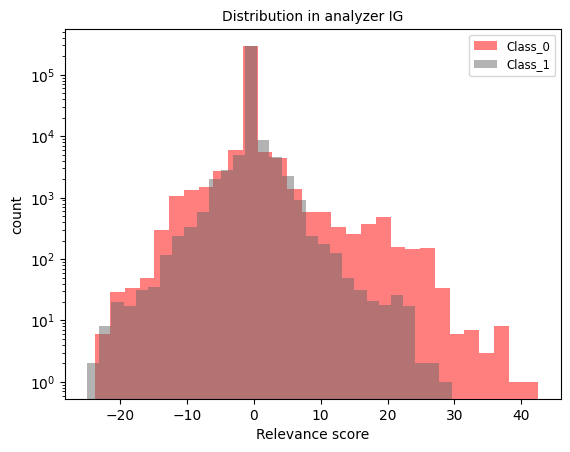

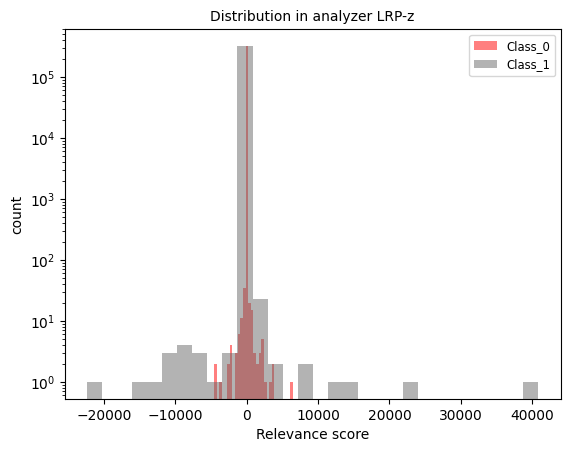

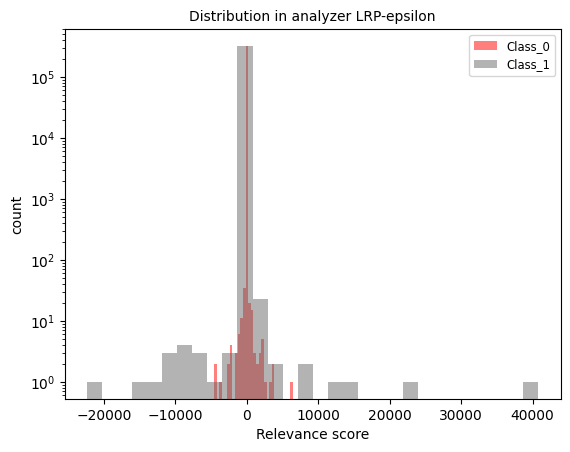

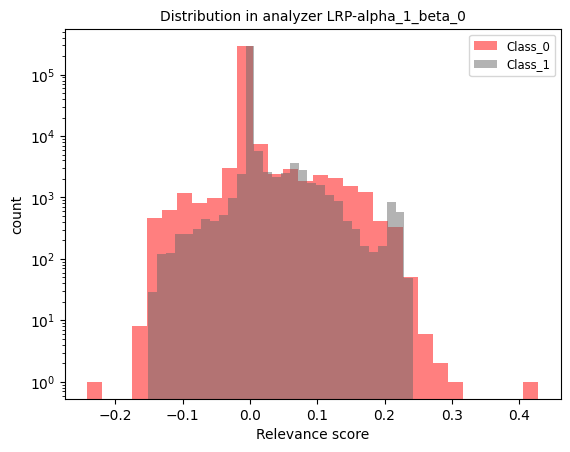

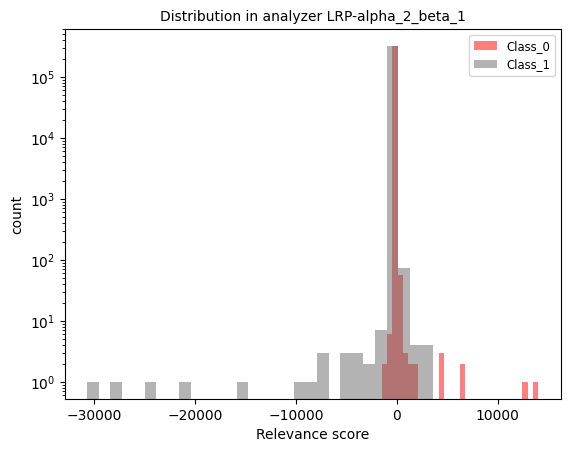

In [67]:
#plot binned over class distribution with histogram
def plot_binned_over_classes_distribution(input, labels, analyzer, analyzer_title):
    """
    Avarage relevance scores over class

    Creates a histogram for the analyzer given as parameter.
    The plot visualize all the classes' analyzer outcomes' distribution
    Classes seperated by the gorund truth labels
    """
    analyzer_output = analyzer.analyze(input)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colors = [(1, 0, 0, 0.5),(0, 0, 1, 0.5),(0, 1, 0, 0.5)]
    colors=['red', 'dimgray', 'lightgray']
    alpha_val = 0.5
    classes = ['Class_0', 'Class_1', 'Class_2']
    possible_classes = [0,1]

# Create the histogram plot
    for class_num in possible_classes:
        class_indices = get_truth_class_indices(class_num, labels)
        class_values = input[class_indices]
        analyzer_class = analyzer_output[class_indices]
        if class_values.shape[0] == 0:
            continue
        ax.hist(analyzer_class.flatten(), bins=30, color=colors[class_num], alpha = alpha_val, label=classes[class_num])
    ax.set_title(f"Distribution in analyzer {analyzer_title}")
    ax.title.set_size(10)
    ax.set_yscale("log")
    ax.legend(fontsize = 'small')
    ax.set_ylabel('count')
    ax.set_xlabel('Relevance score')
    plt.savefig(f"{Path.cwd()}\..\plots\latest\ecg\hist_plot_distribution\{analyzer_title}.png")
    plt.show()

for name,analyzer in analyzers.items():
    plot_binned_over_classes_distribution(test_x, test_y, analyzer, name)


In [ ]:
from scipy.stats import gaussian_kde
def plot_grouped_boxplot(predictions, class_num, analyzer, input, labels,  analyzer_title):
    analyzer_output = analyzer.analyze(input)
    class_probabilities = predictions[:, class_num]

    """
    bin_edges = np.arange(0, 1.01, 0.1)
    columns = []
    for start, end in zip(bin_edges[:-1], bin_edges[1:]):
        indices = np.where((class_probabilities >= start) & (class_probabilities < end))
        rel_bin = analyzer_output[indices].flatten()
        columns.append(rel_bin)

    plt.figure(figsize=(20, 12))
    flierprops = dict(marker='o', markersize=3, linestyle='none', markeredgecolor='red')
    for i, rel_bin in enumerate(columns):
        bin_mid_point = (bin_edges[i] + bin_edges[i+1]) / 2
        if rel_bin.size > 0:
            plt.boxplot(rel_bin, positions=[bin_mid_point], widths=0.005, flierprops=flierprops, patch_artist=True, boxprops = dict(facecolor = "gray"), showmeans=True, meanprops = dict(color = "red", linewidth = 5), medianprops = dict(color = "black", linewidth = 5))
            #plt.boxplot(rel_bin, positions=[bin_mid_point], widths=0.005, flierprops=flierprops, showmeans=True, meanprops = dict(color = "green", linewidth = 5))
    """
    #class indices based on the labels
    correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, class_num)
    false_neg_indices_for_class = get_false_negative_indices(predictions, labels, class_num)
    false_pos_indices_for_class = get_false_positive_indices(predictions, labels, class_num)
    incorrect_indices_for_class = get_incorrect_prediction_indices_for_class(predictions, labels, class_num)

    #class values compared to the predictions
    correct_input_for_class = input[correct_indices_for_class]
    false_neg_input_for_class = input[false_neg_indices_for_class]
    false_pos_input_for_class = input[false_pos_indices_for_class]
    incorrect_input_for_class = input[incorrect_indices_for_class]

    #analyzer values for class based on the predictions
    correct_analyzer_for_class = analyzer_output[correct_indices_for_class]
    false_neg_analyzer_for_class = analyzer_output[false_neg_indices_for_class]
    false_pos_analyzer_for_class = analyzer_output[false_pos_indices_for_class]
    incorrect_analyzer_for_class = analyzer_output[incorrect_indices_for_class]


    # Plotting
    plt.figure(figsize=(20, 12))
    flierprops = dict(marker='o', markersize=3, linestyle='none', markeredgecolor='red')
    pos = [ i+1 for i in range(len(analyzer_output))]
    #plt.boxplot(columns, positions=pos, widths=0.005, flierprops=flierprops, patch_artist=True, boxprops = dict(facecolor = "gray"), showmeans=True, meanprops = dict(color = "red", linewidth = 5), medianprops = dict(color = "black", linewidth = 5))
    #plt.boxplot(rel_bin, positions=[bin_mid_point], widths=0.005, flierprops=flierprops, showmeans=True, meanprops = dict(color = "green", linewidth = 5))
    #plt.boxplot(correct_analyzer_for_class.T, widths=0.005)
    analyzer_trans = analyzer_output.T
    predicted_class = get_predicted_classes(predictions)
    means = np.mean(analyzer_trans, axis=0)

    # Sort the means and corresponding data and predictions
    sorted_indices = np.argsort(means)
    sorted_analyzer_trans = analyzer_trans[:, sorted_indices]
    sorted_predicted_class = predicted_class[sorted_indices]

    boxplot_data_red = []
    boxplot_data_gray = []
    red_pos = []
    gray_pos = []

    for i in range(sorted_analyzer_trans.shape[1]):
        if sorted_predicted_class[i] == class_num:
            boxplot_data_red.append(analyzer_trans[:, i])
            red_pos.append(i)
        else:
            boxplot_data_gray.append(analyzer_trans[:, i])
            gray_pos.append(i)

    # Plot boxplots for the predicted class in red
    c = 'red'

    plt.boxplot(boxplot_data_red, positions=red_pos, patch_artist=True, boxprops=dict(facecolor=c, color=c),
            showfliers = False,
            medianprops=dict(color='green'))

    # Plot boxplots for the other class in gray
    c = 'gray'
    plt.boxplot(boxplot_data_gray, positions=gray_pos, patch_artist=True, boxprops=dict(facecolor=c, color=c),
            showfliers=False,
            medianprops=dict(color='green'))

    plt.title(f"{analyzer_title} vs. Probability of Class {class_num} Presence")
    plt.xlabel(f"Probability of Class {class_num} Presence")
    plt.ylabel("Relevance Scores")
    #plt.xlim(bin_edges[0], bin_edges[-1])
    #ylim_lower, ylim_upper = set_dynamic_ylim(analyzer_trans)
    #plt.ylim(ylim_lower, ylim_upper)
    tick_step = 0.1  # Define the step for the x-ticks
    positions = np.arange(bin_edges[0], bin_edges[-1], tick_step)
    plt.xticks(positions, [f"{pos:.2f}" for pos in positions], fontsize=8)
    #plt.xticks(np.arange(0, 1, 0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    #plt.savefig(f"{Path.cwd()}/../plots/synmermite/box_plot_distribution/{analyzer_title}_class_{class_num}.png")
    plt.show()

plot_grouped_boxplot(predictions, 1, analyzers["LRP-z"], test_x, test_y, name)
for name,analyzer in analyzers.items():
    for class_num in [0,1]:
        plot_grouped_boxplot(predictions, class_num, analyzer, test_x, test_y, name)
        break
    break

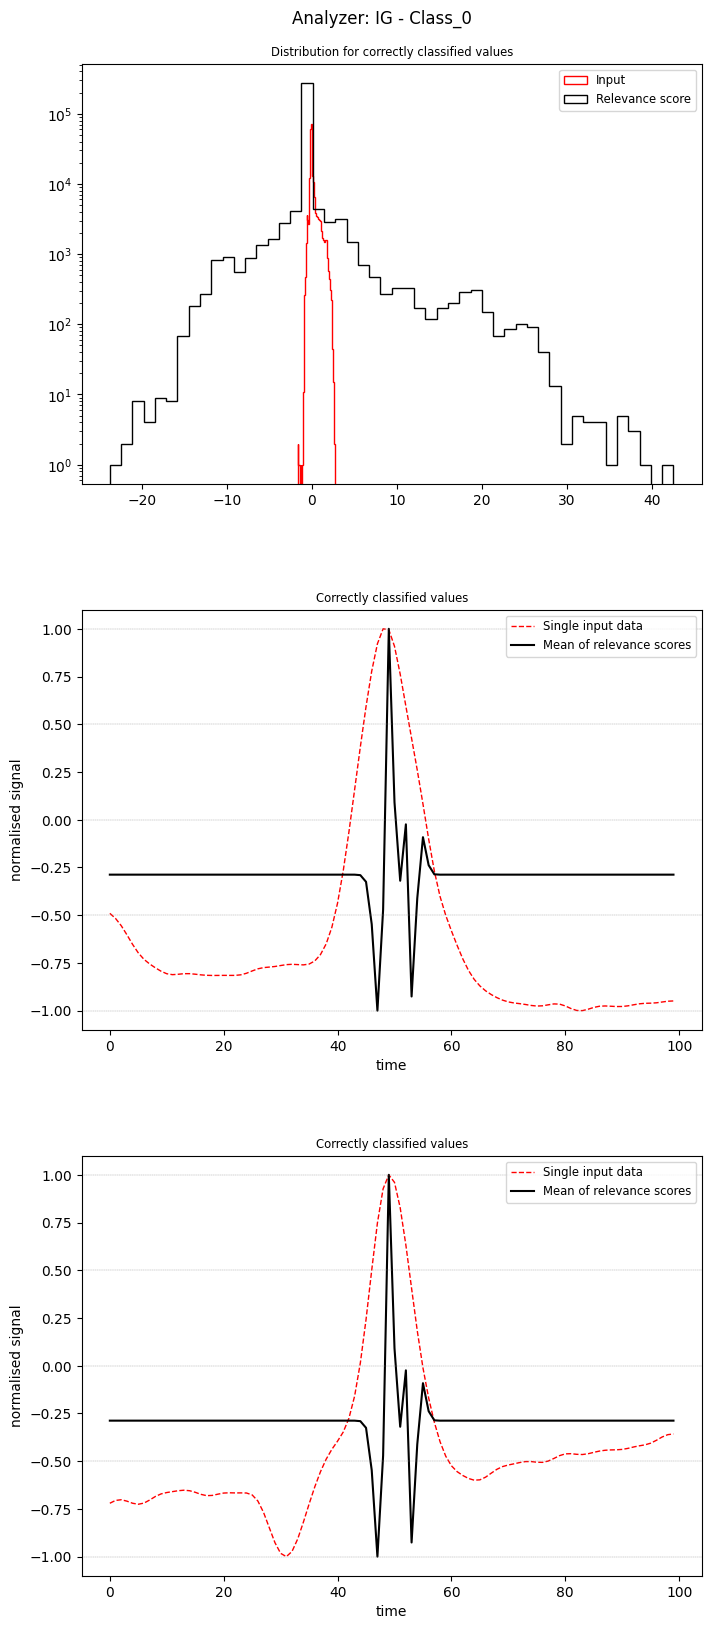

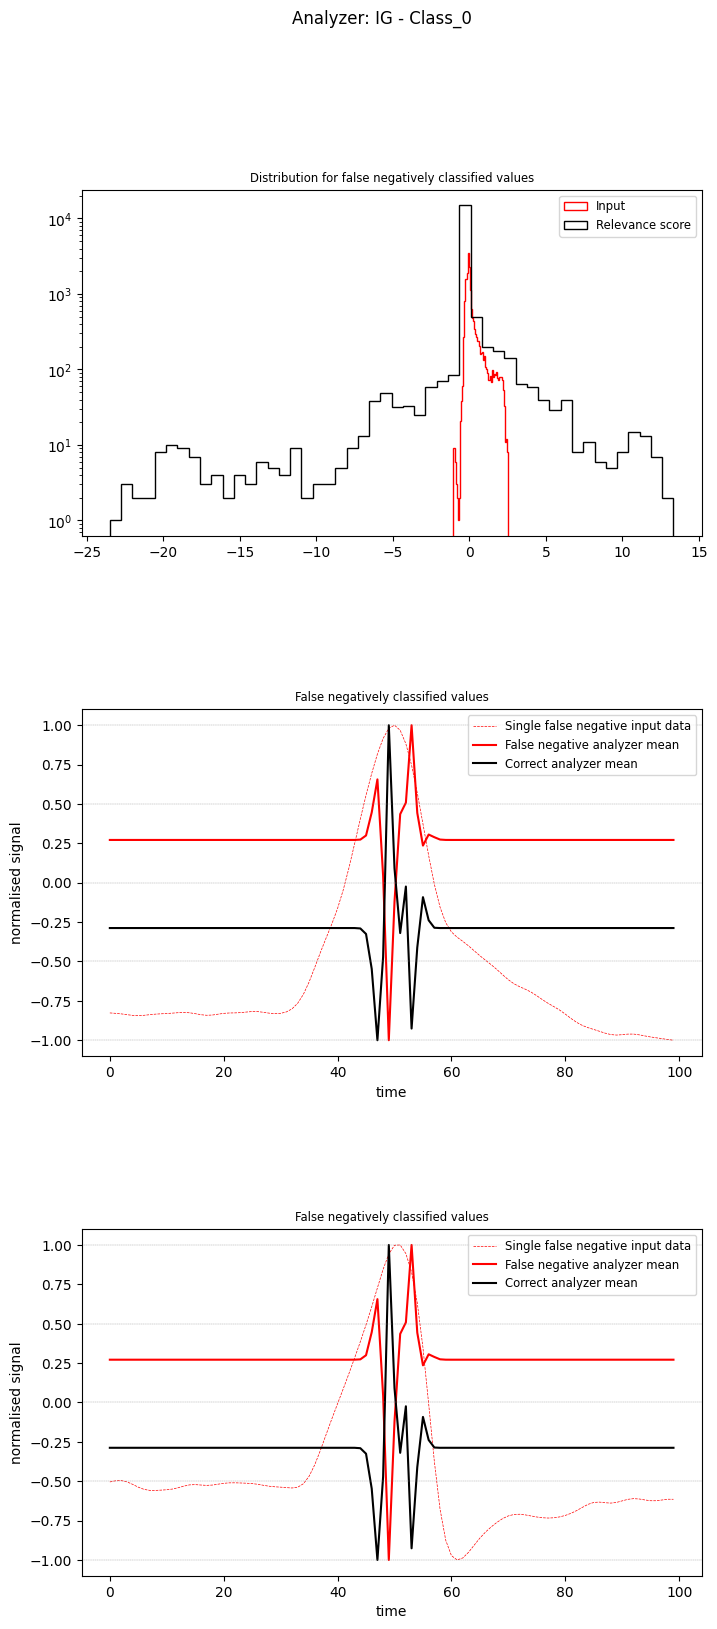

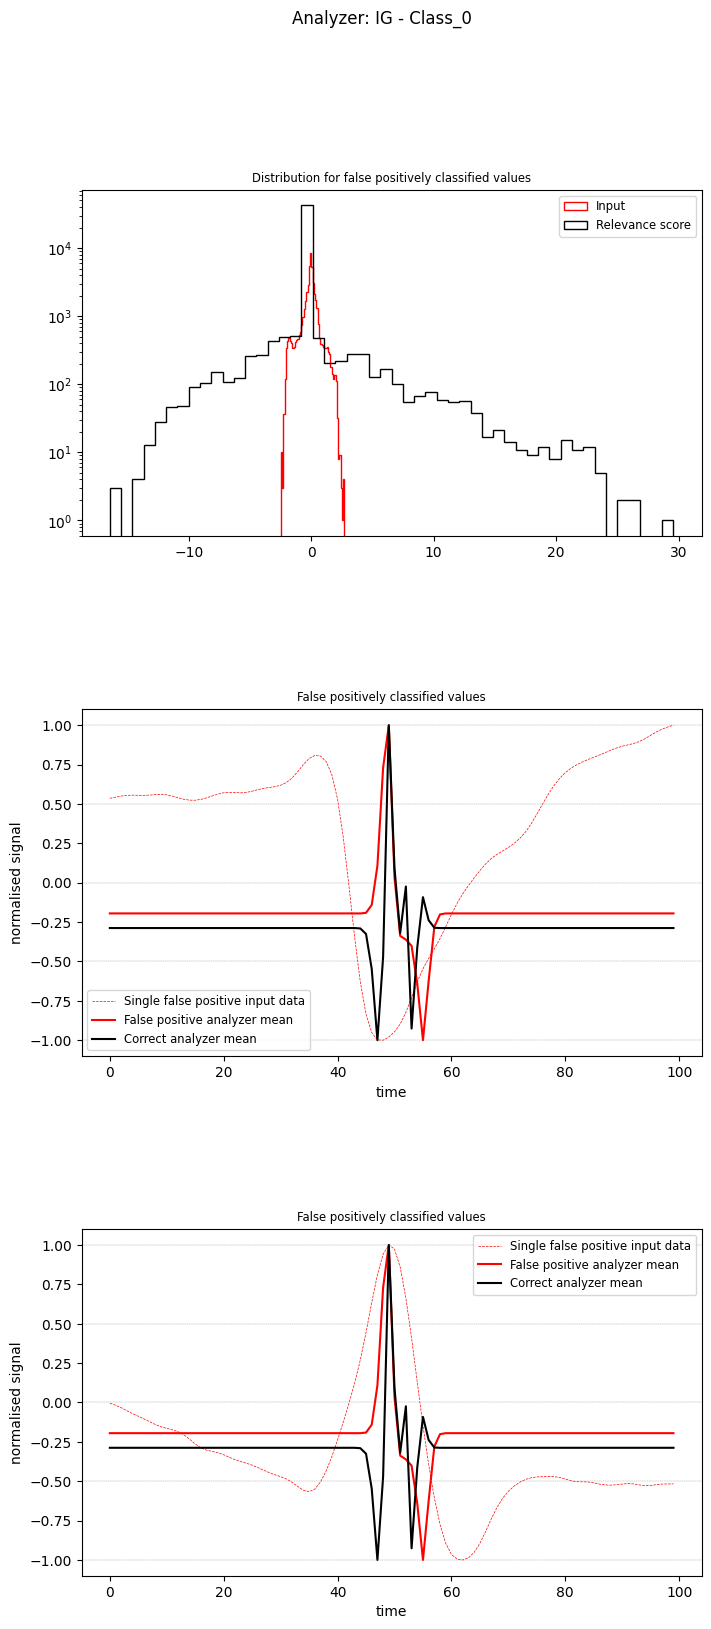

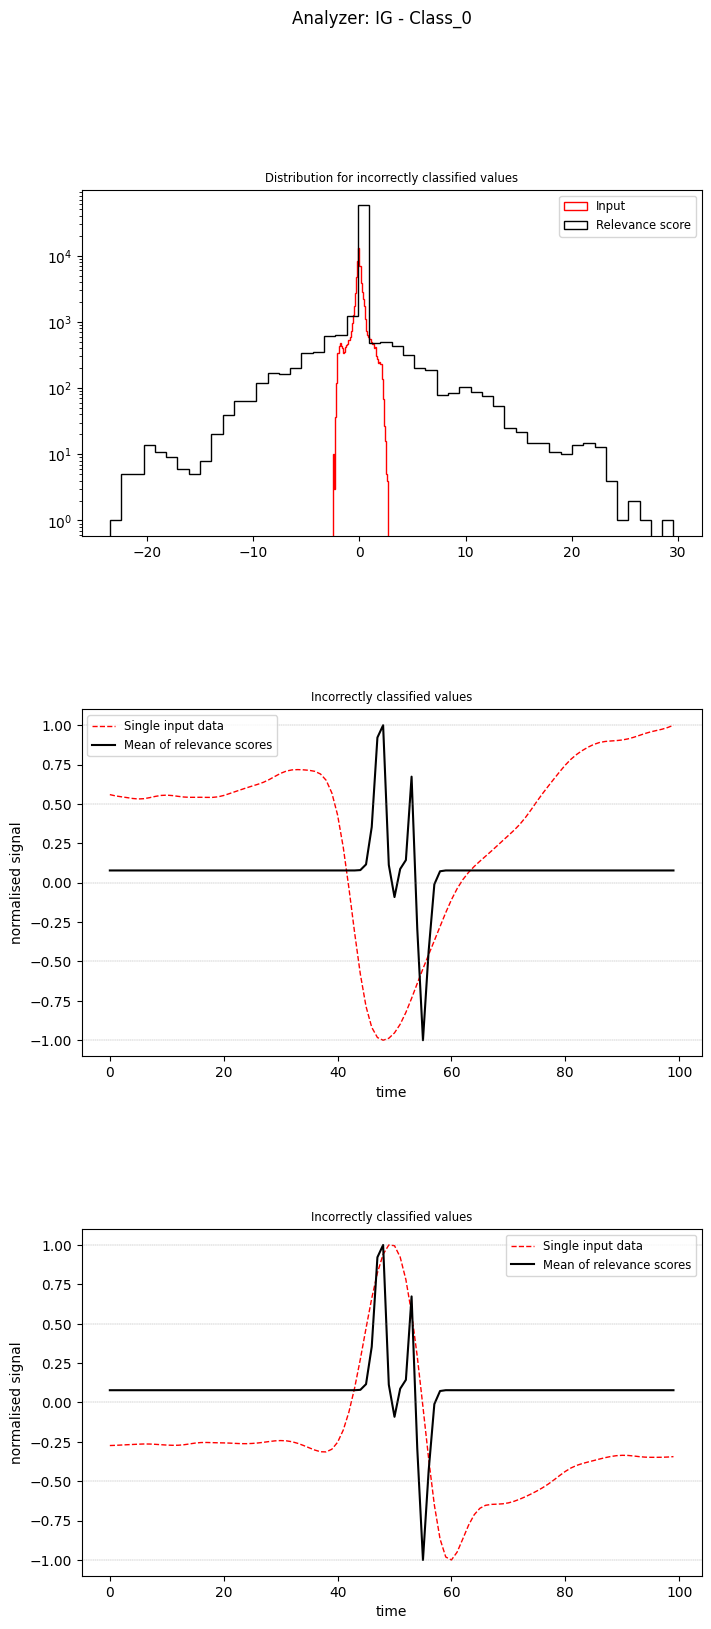

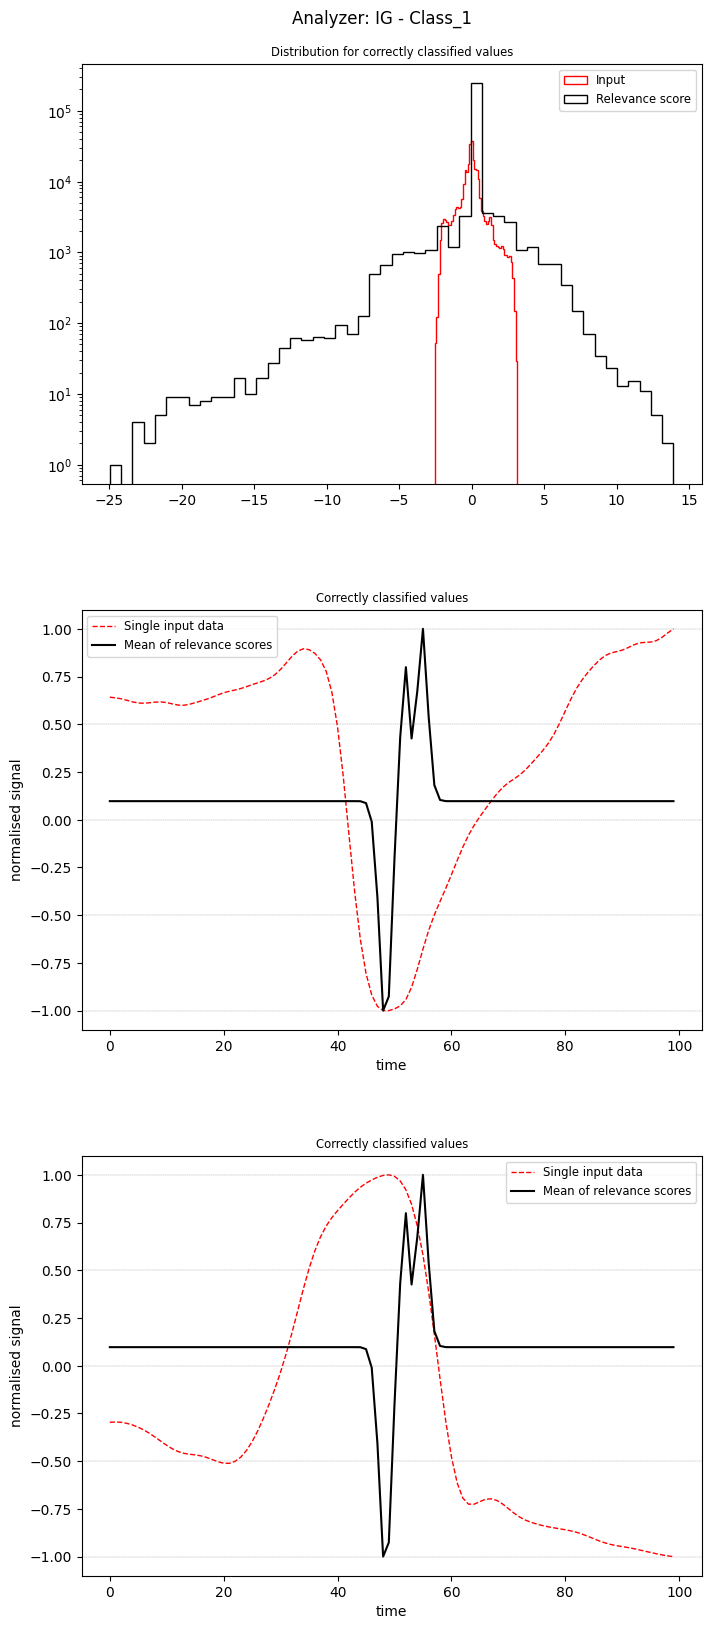

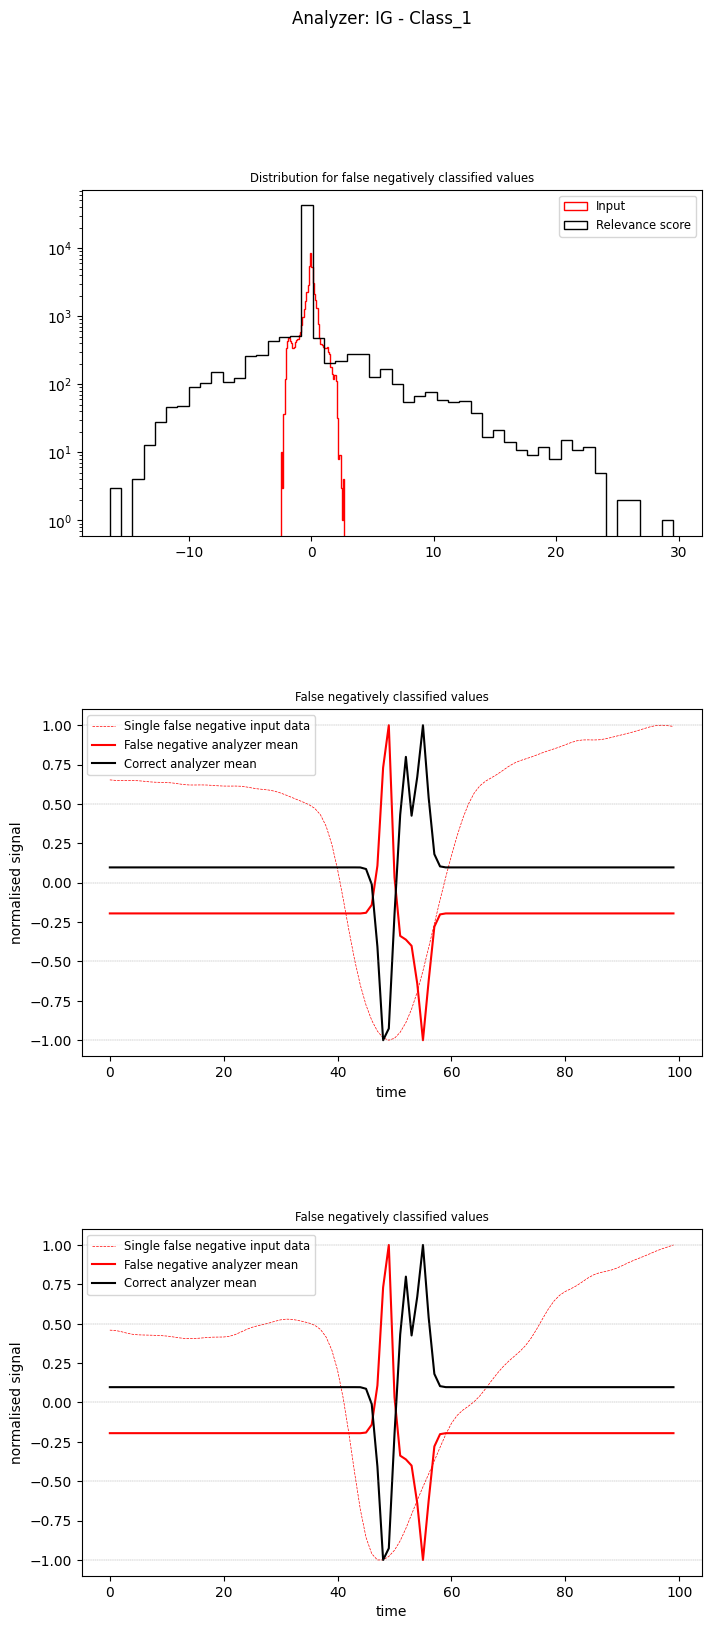

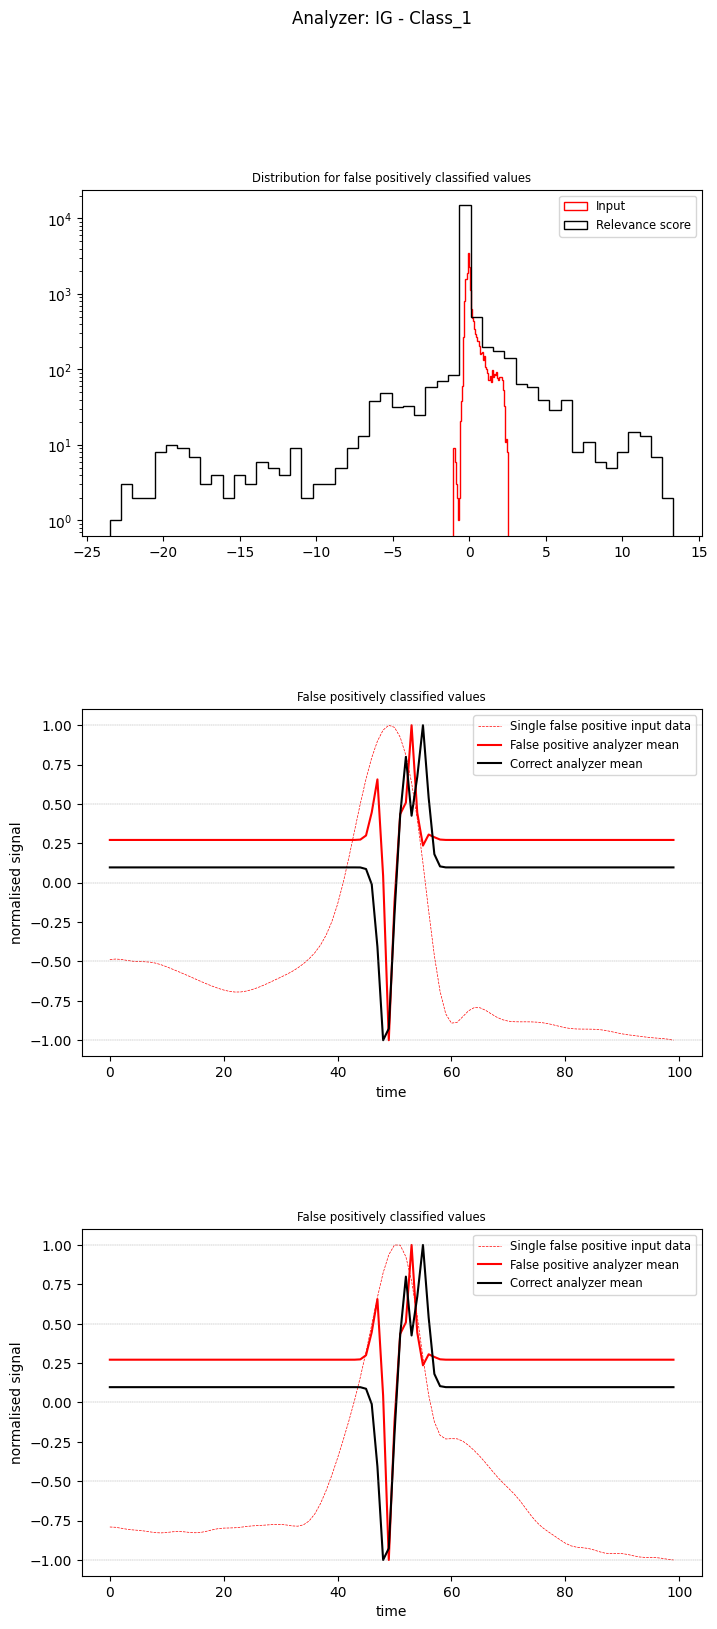

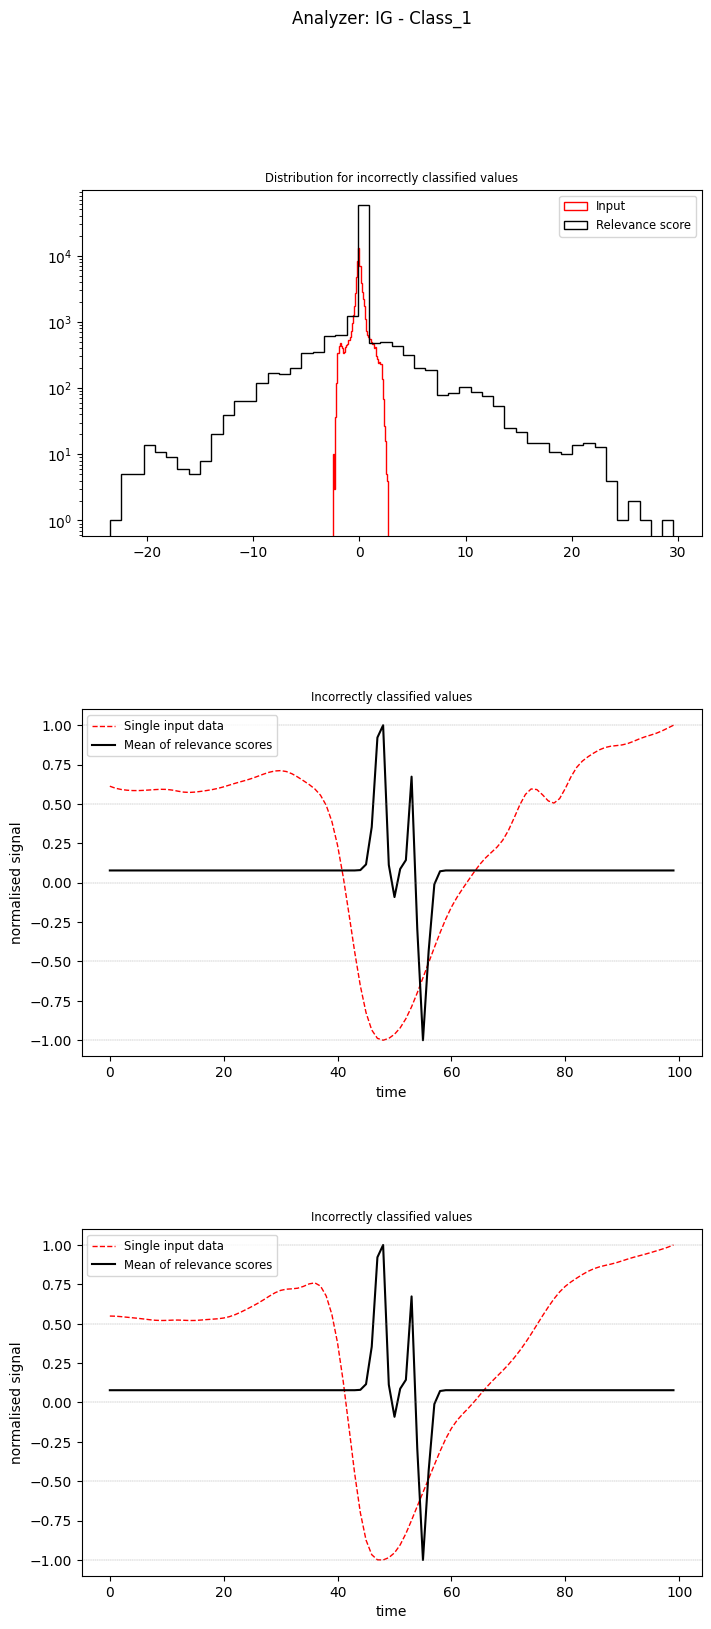

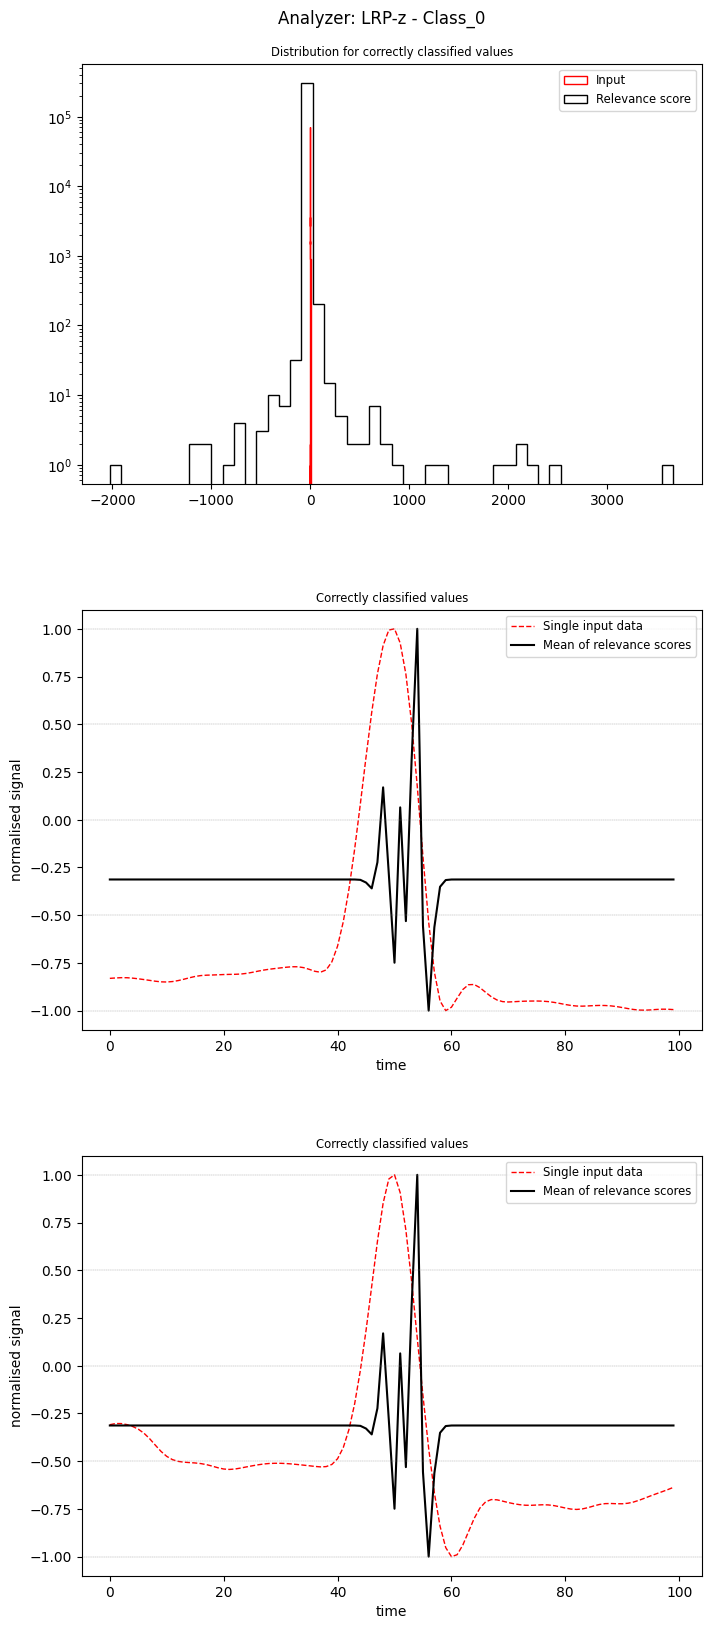

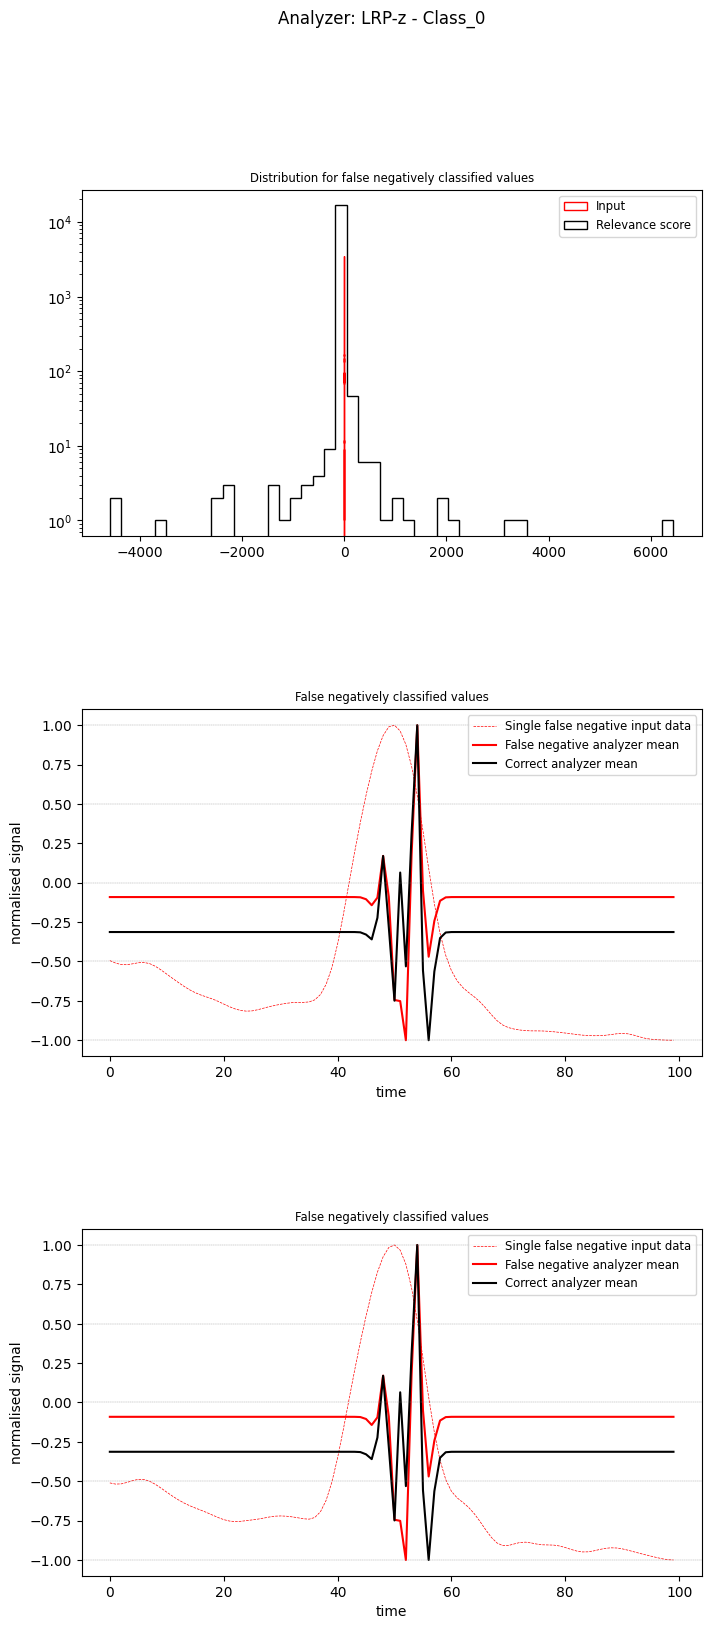

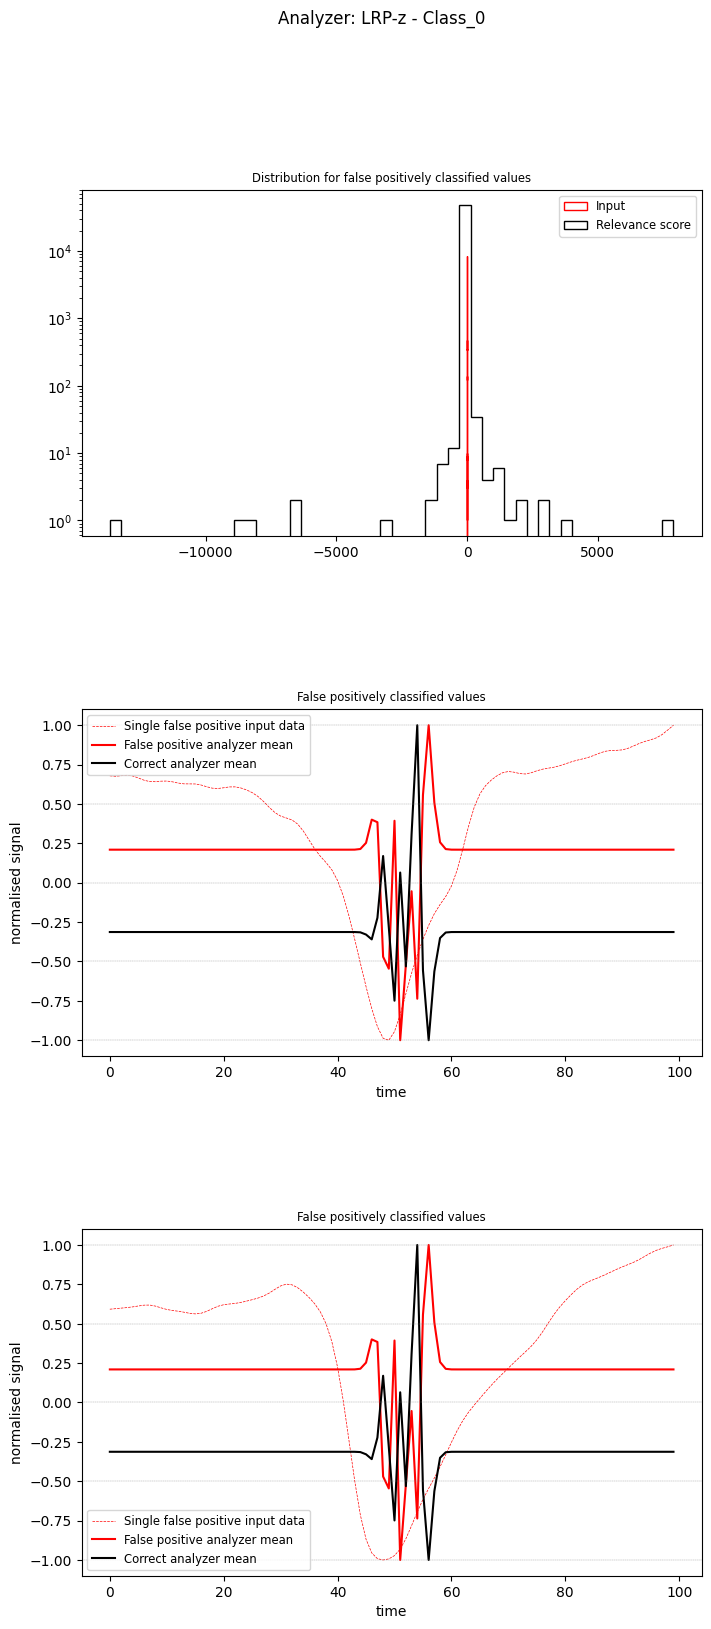

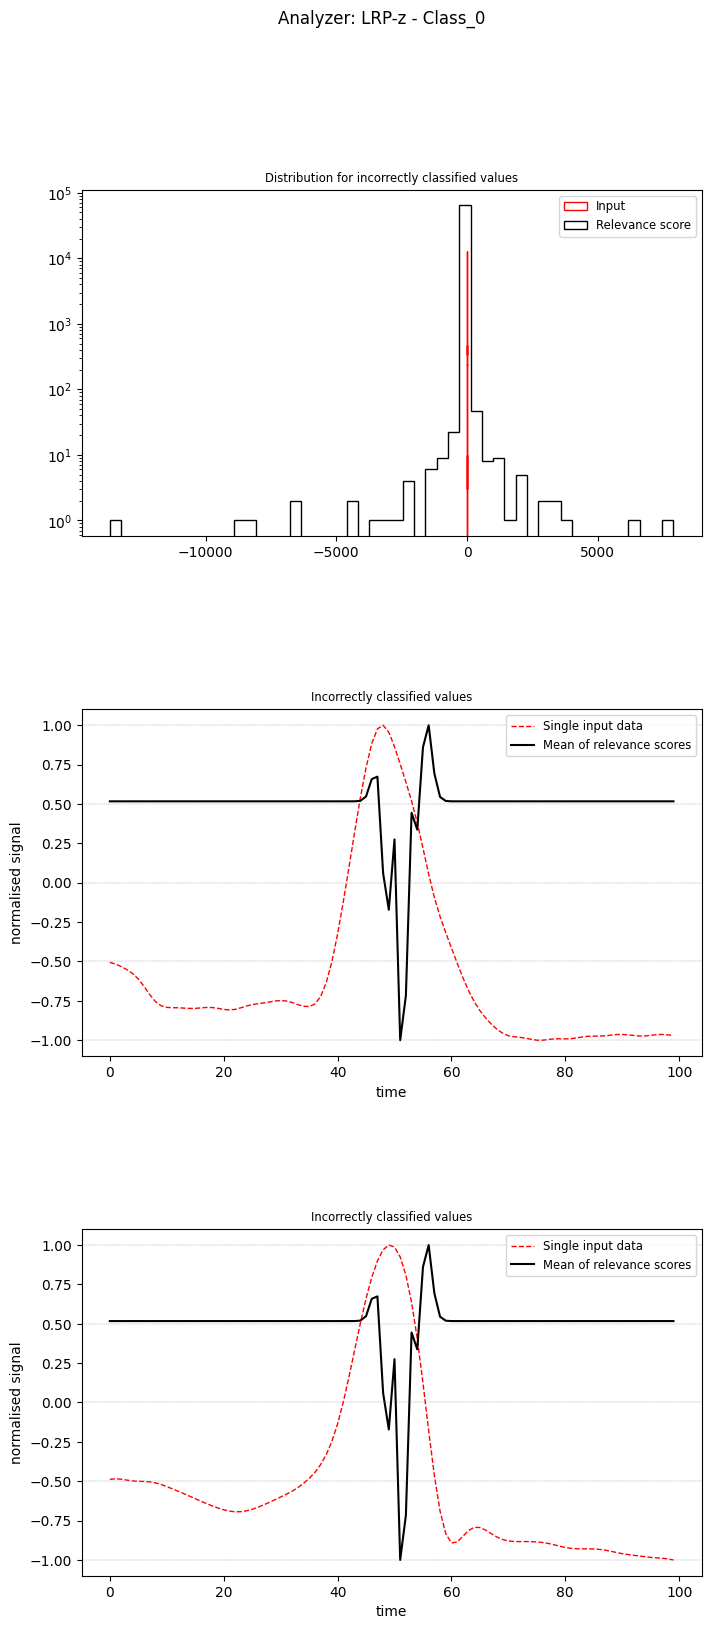

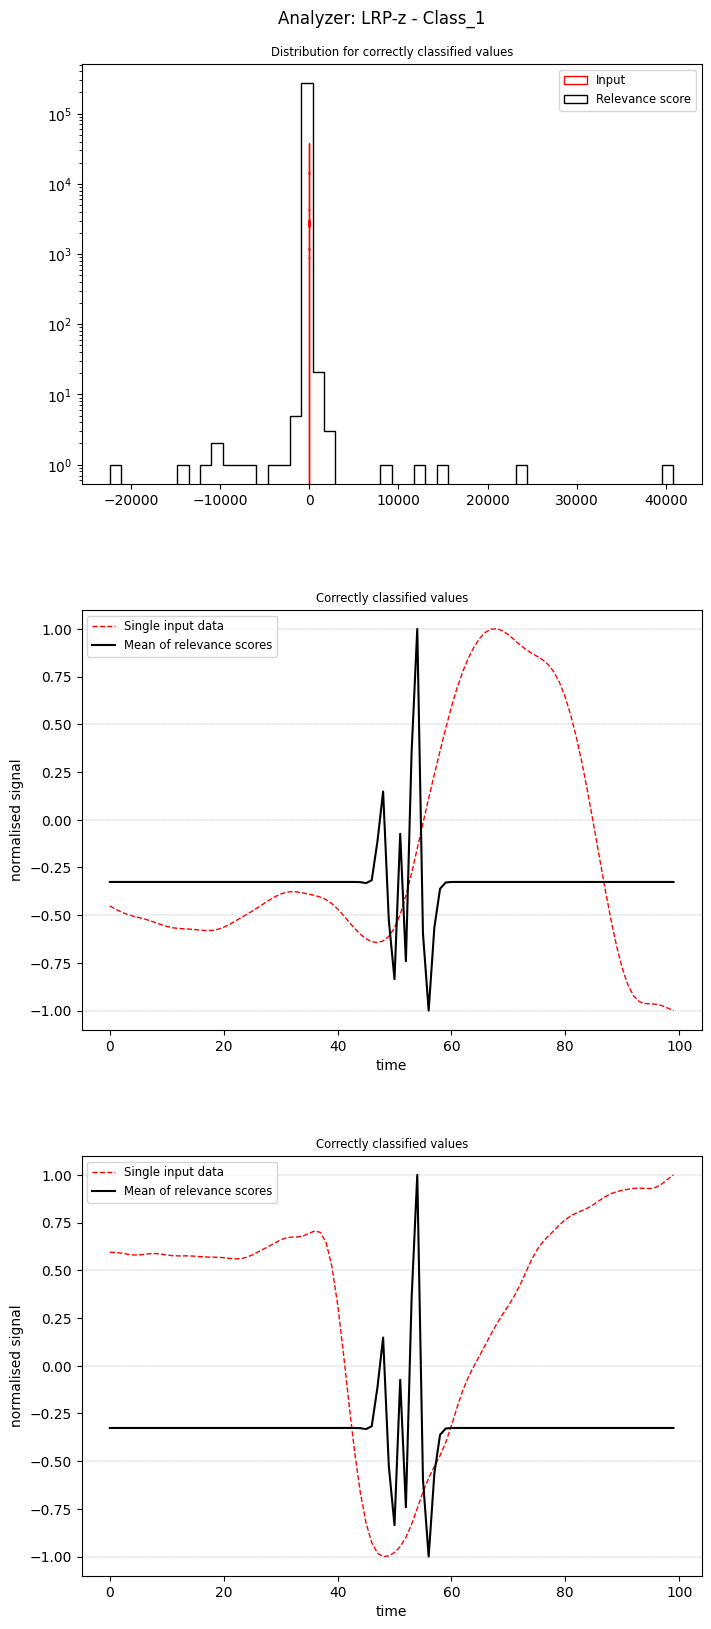

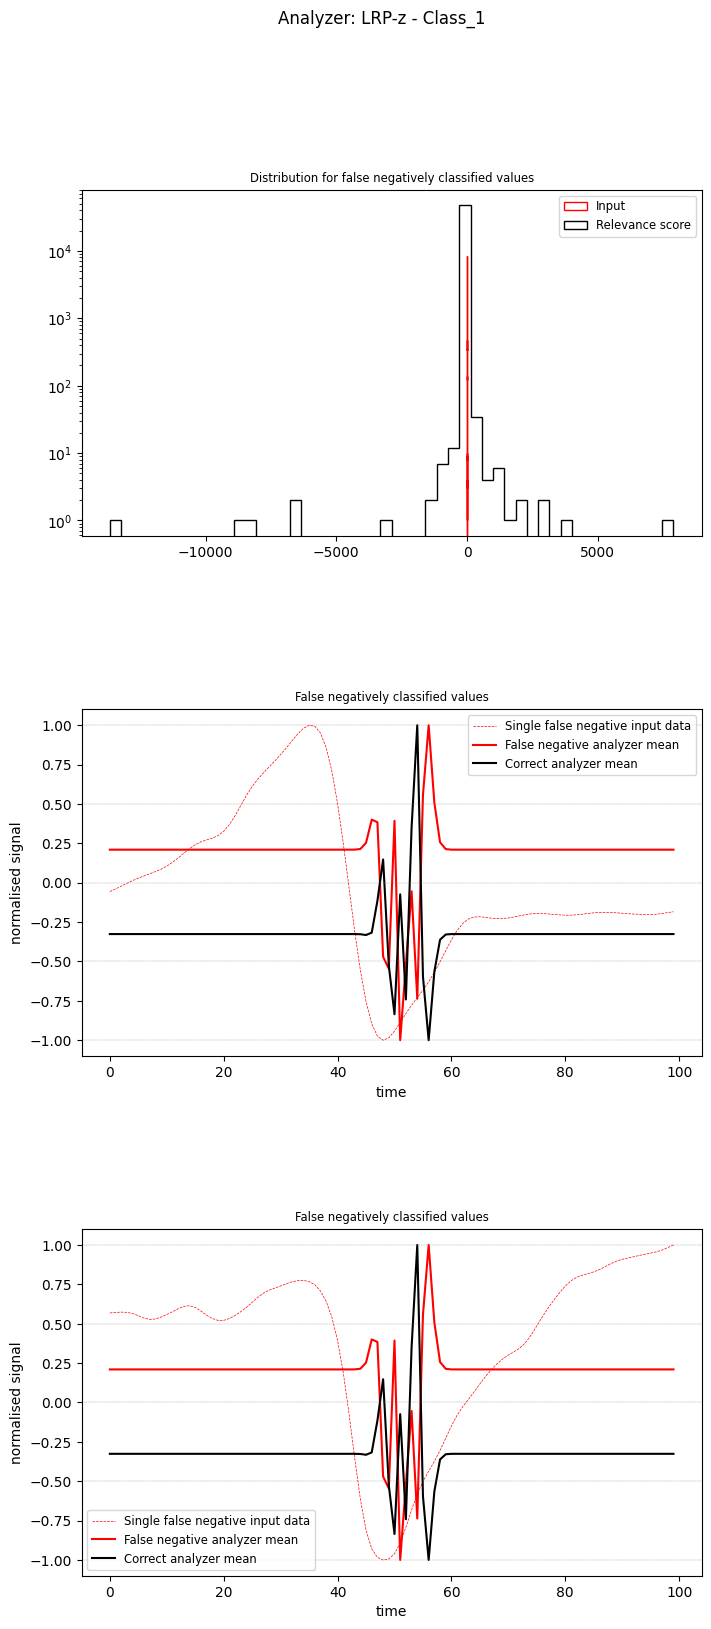

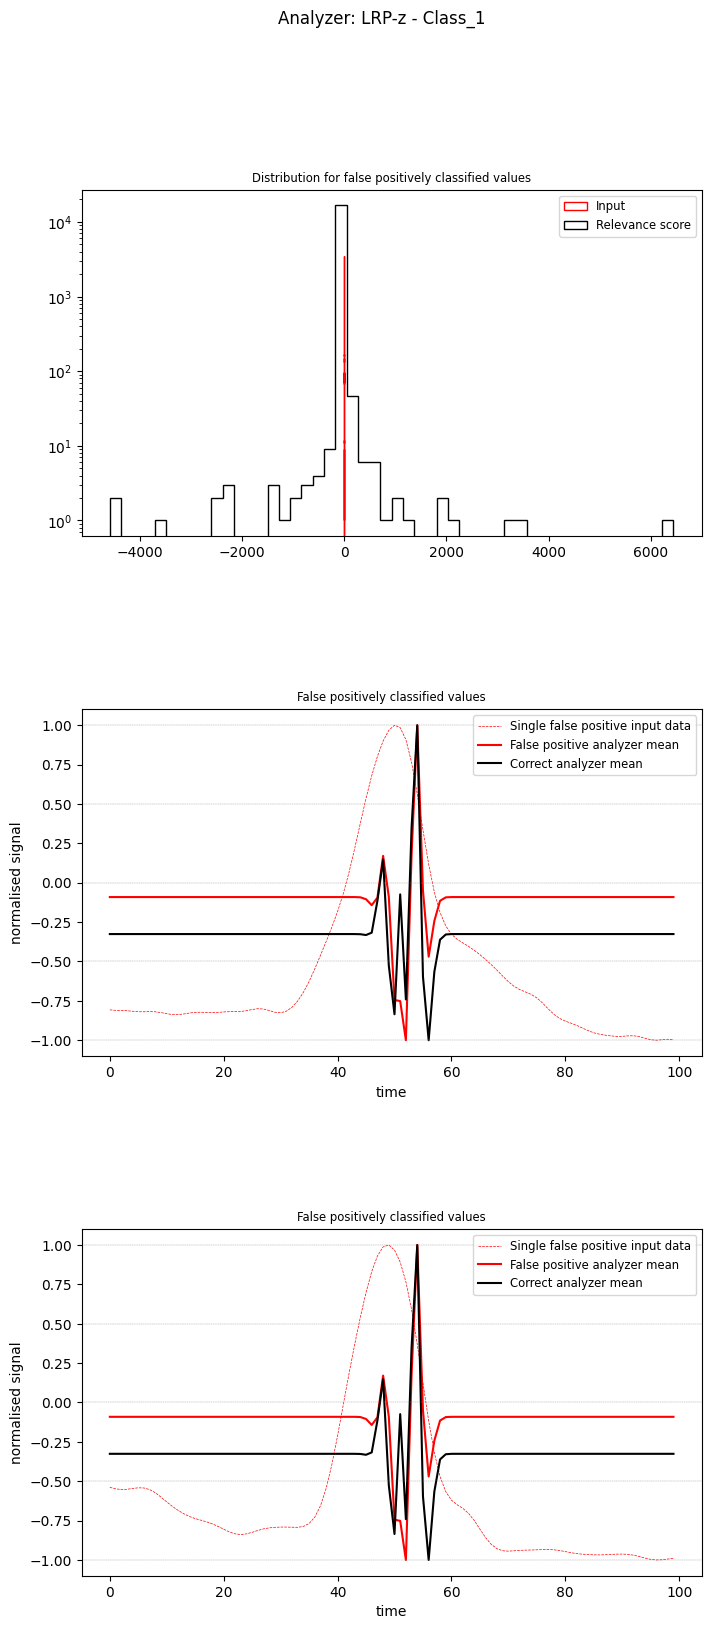

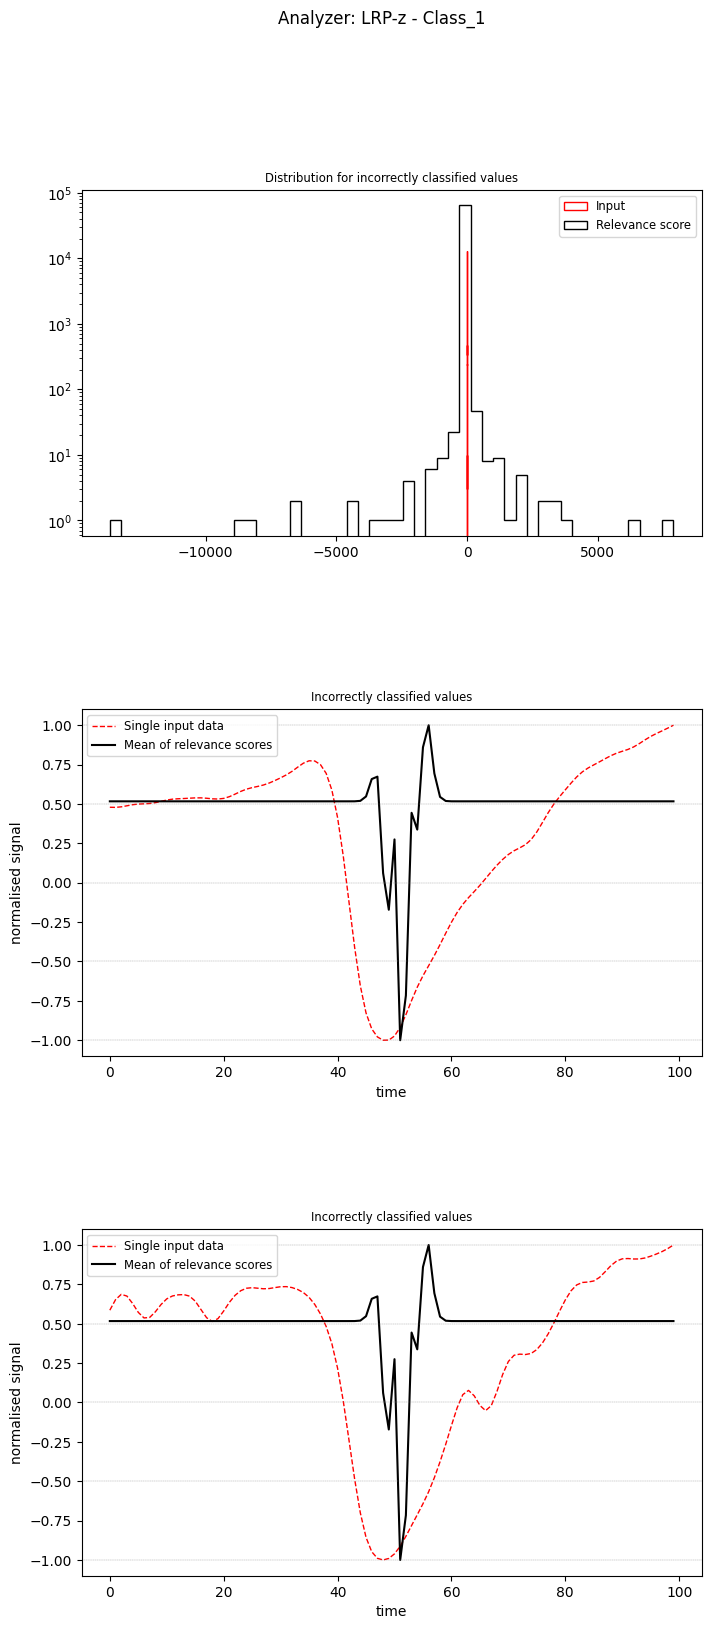

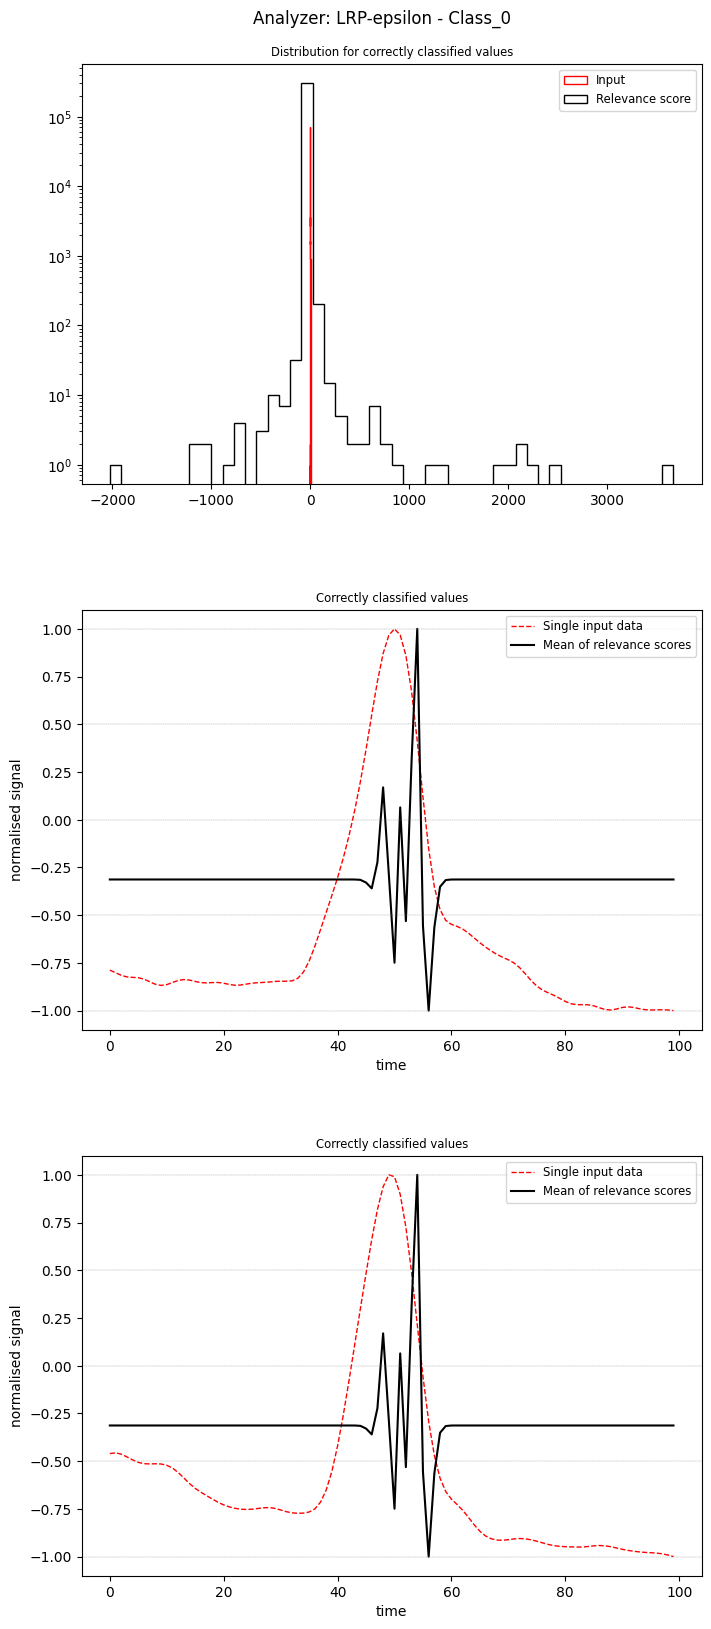

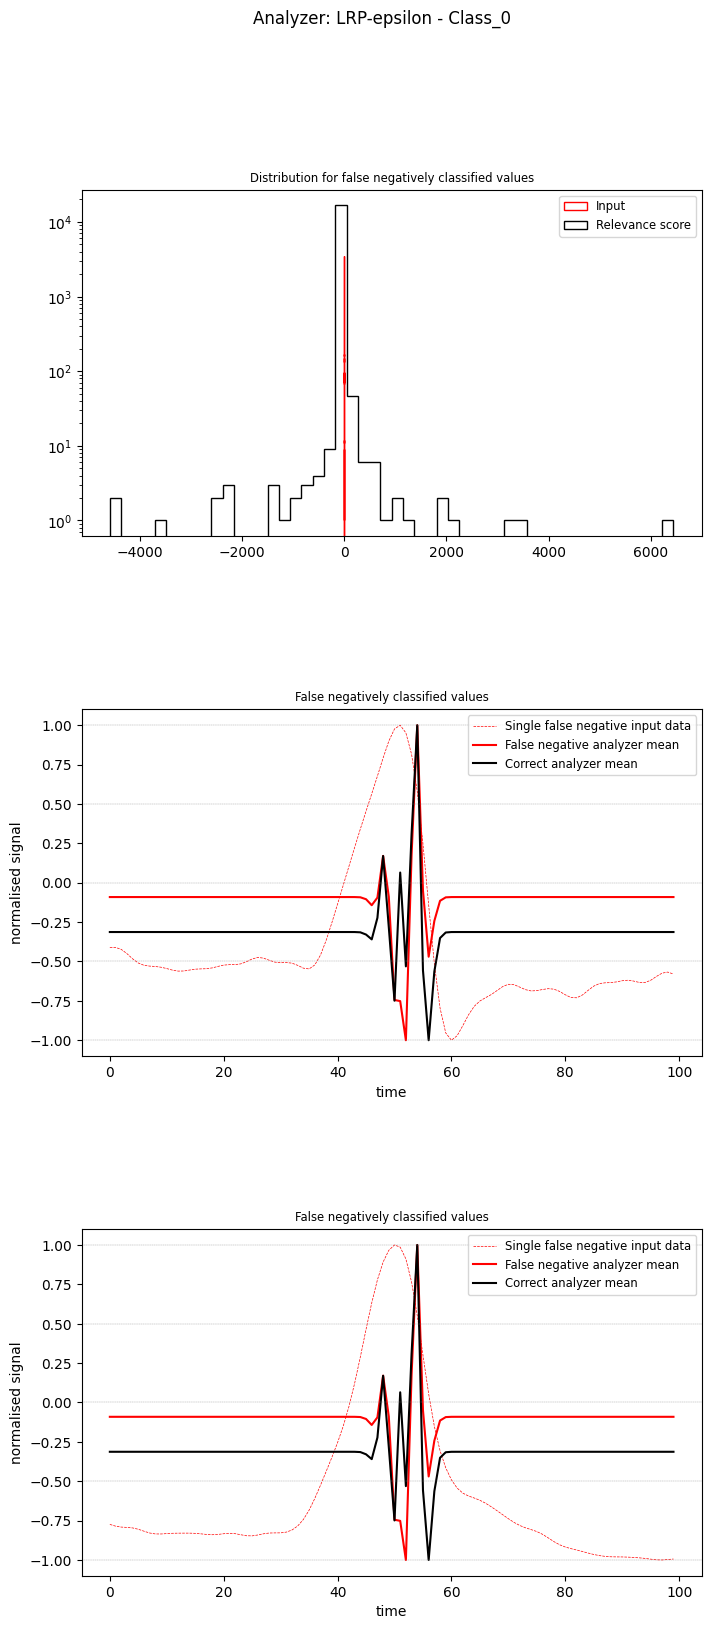

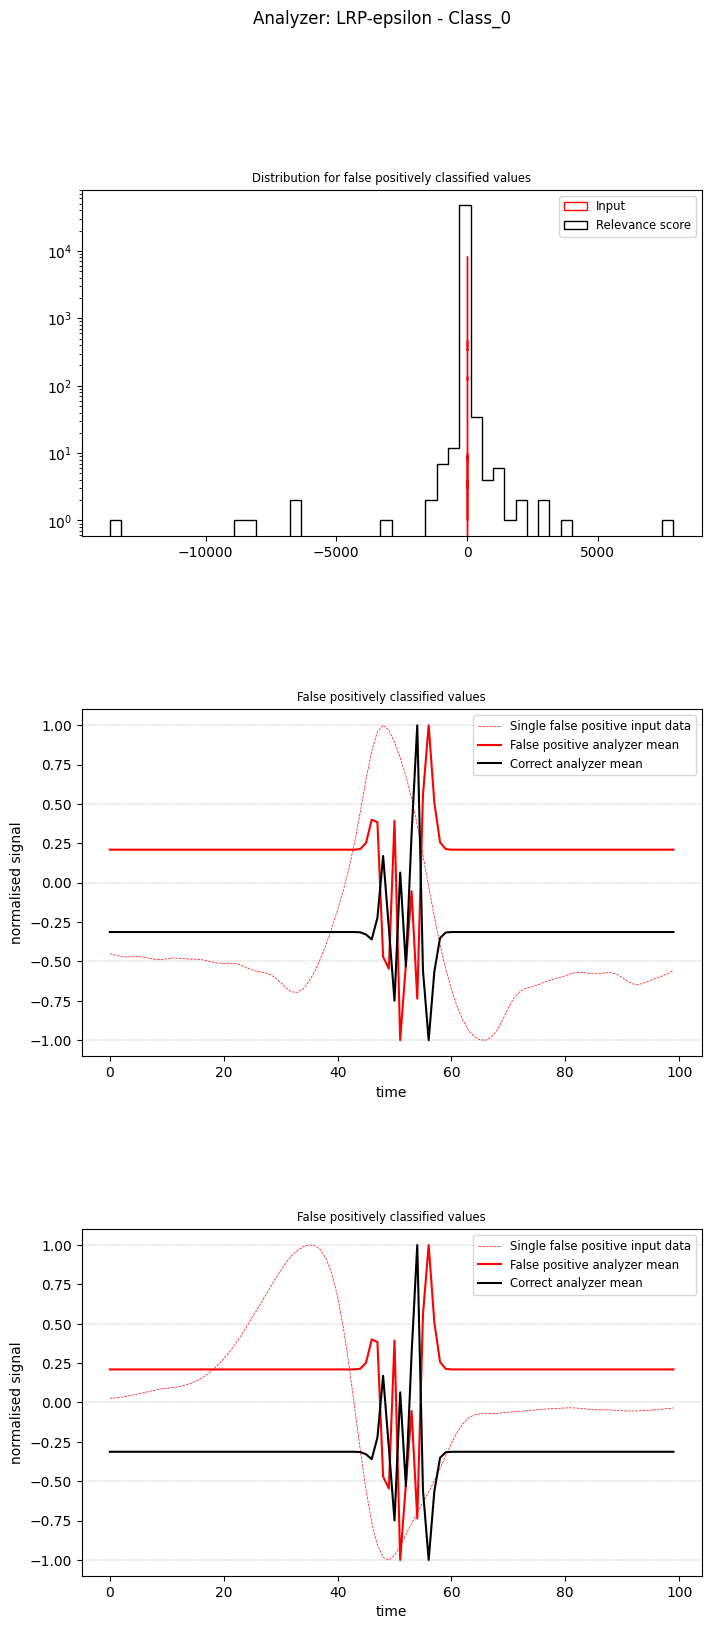

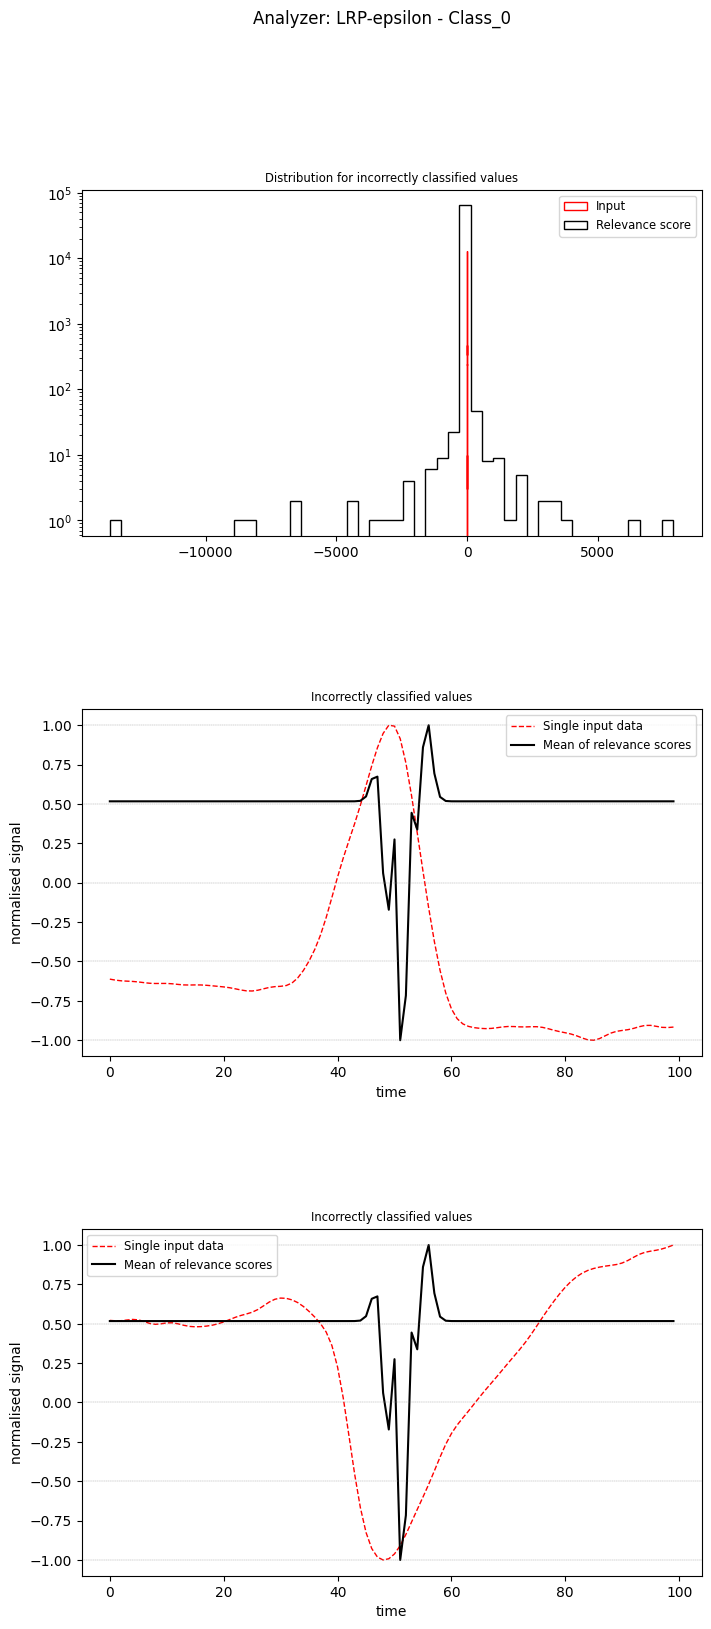

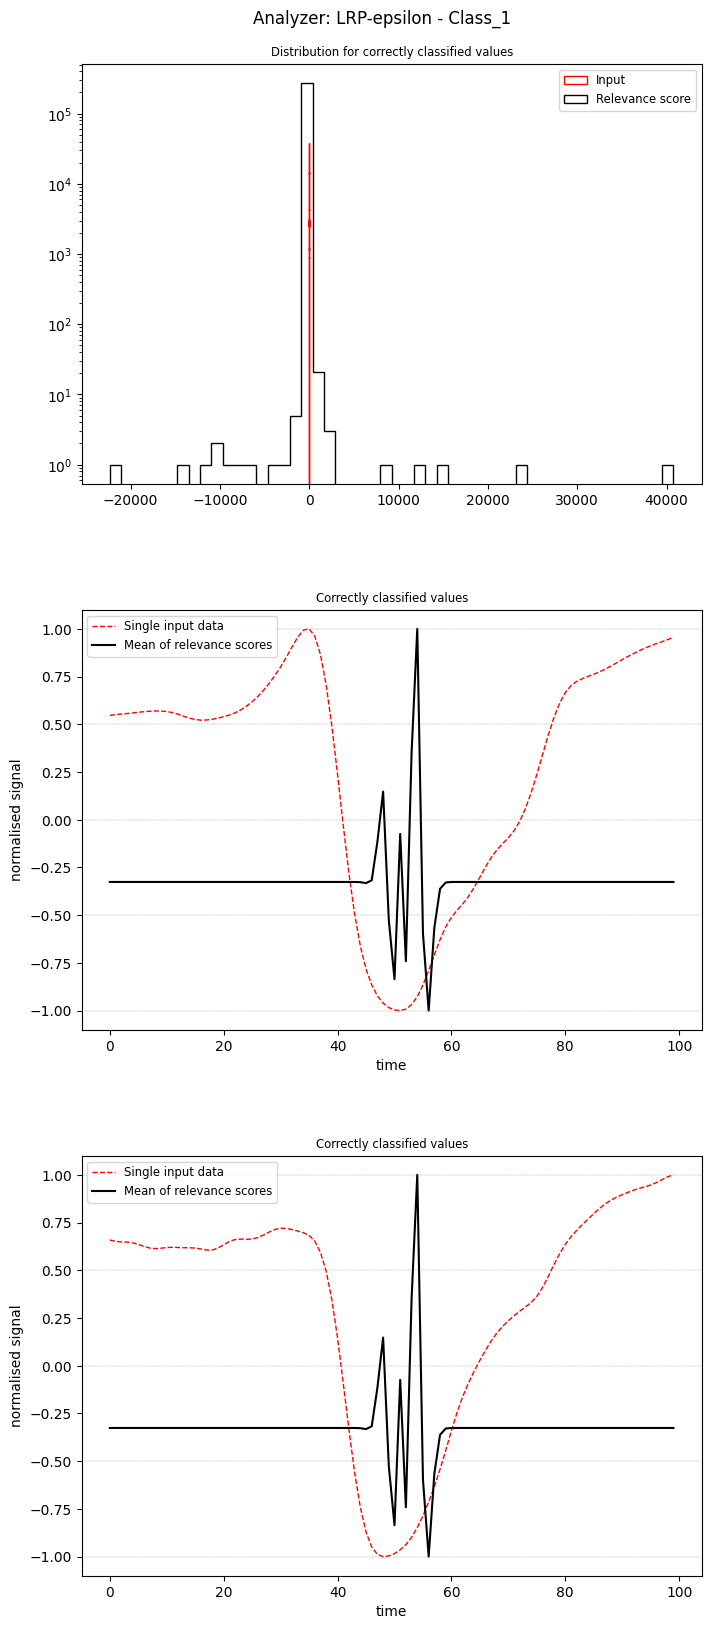

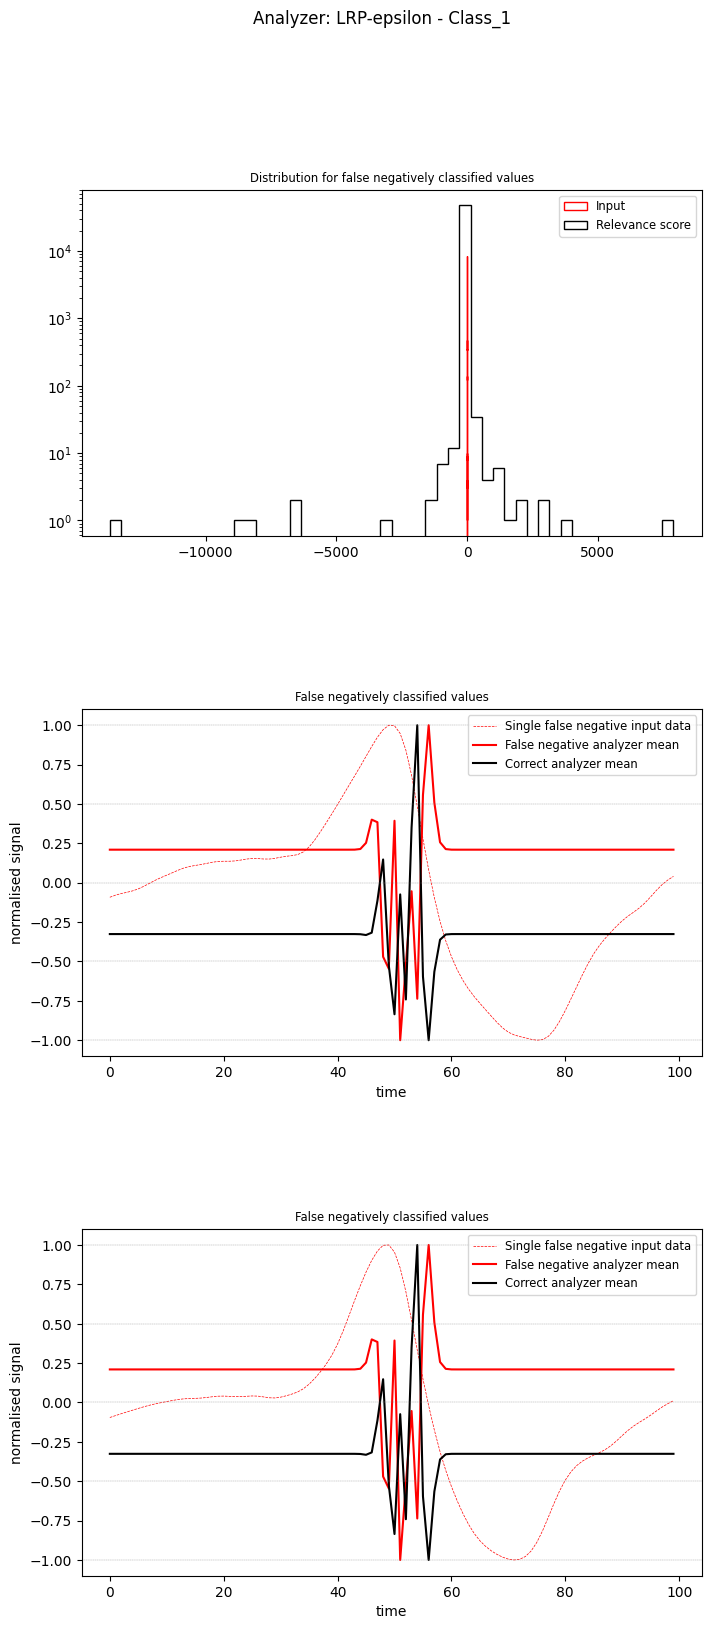

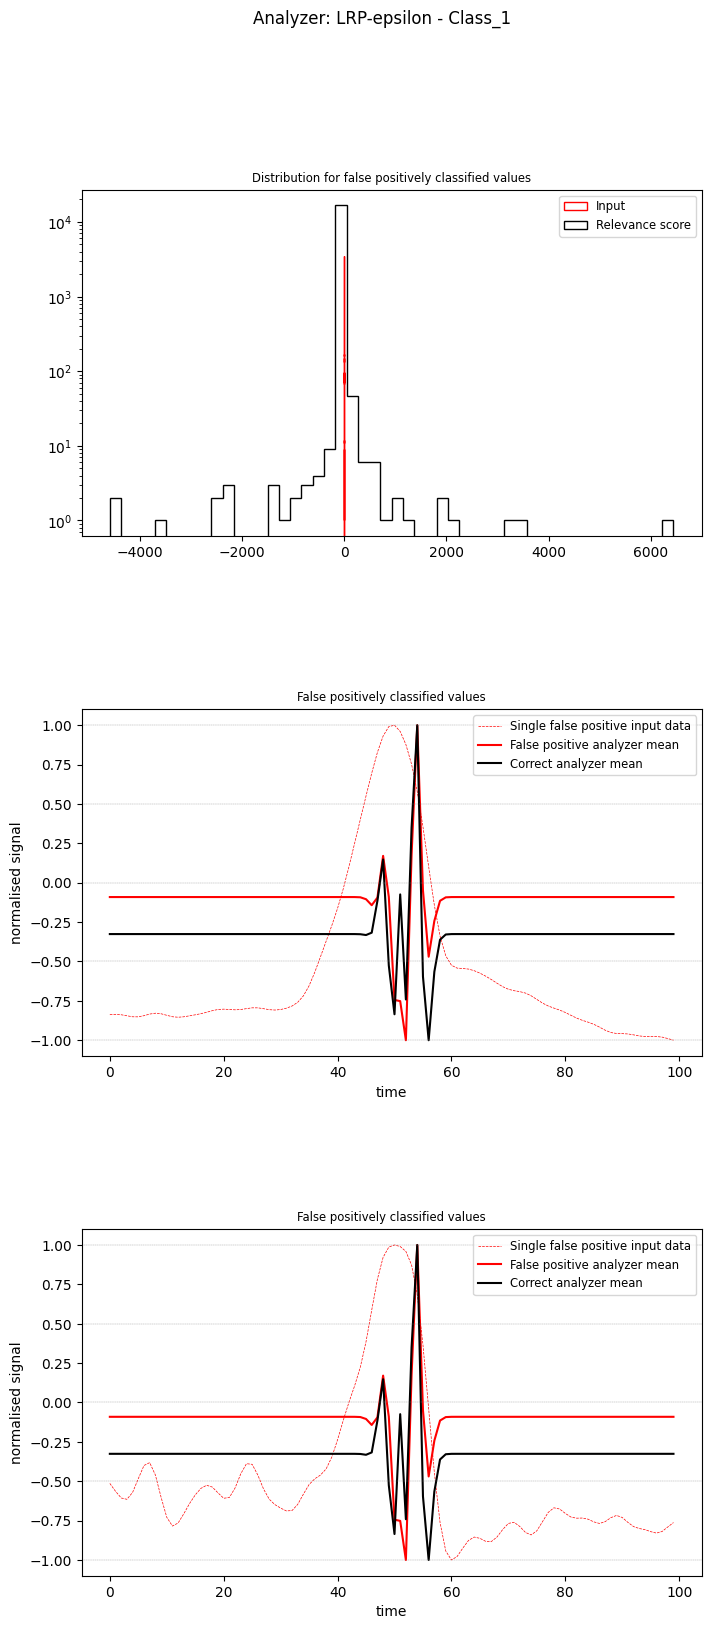

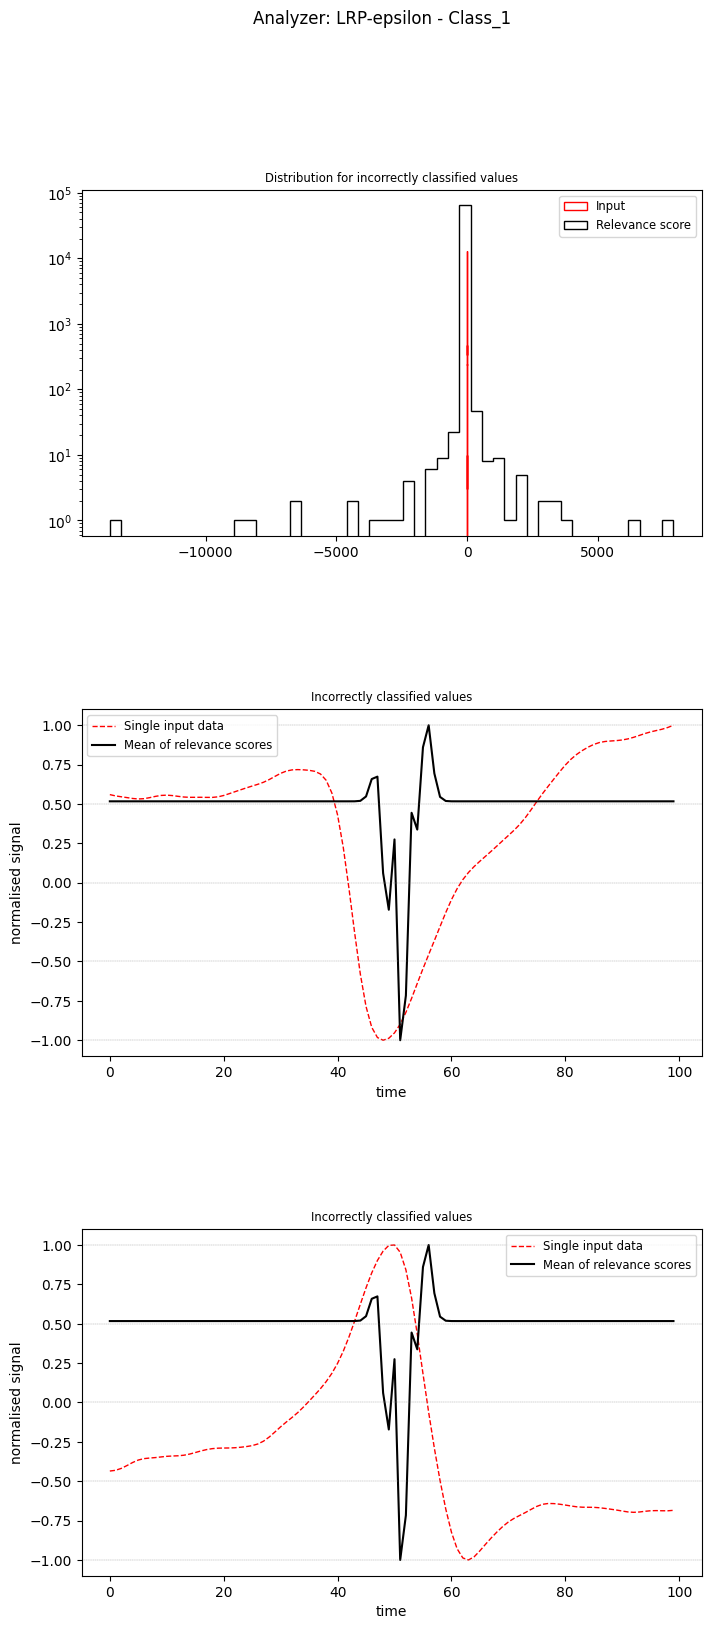

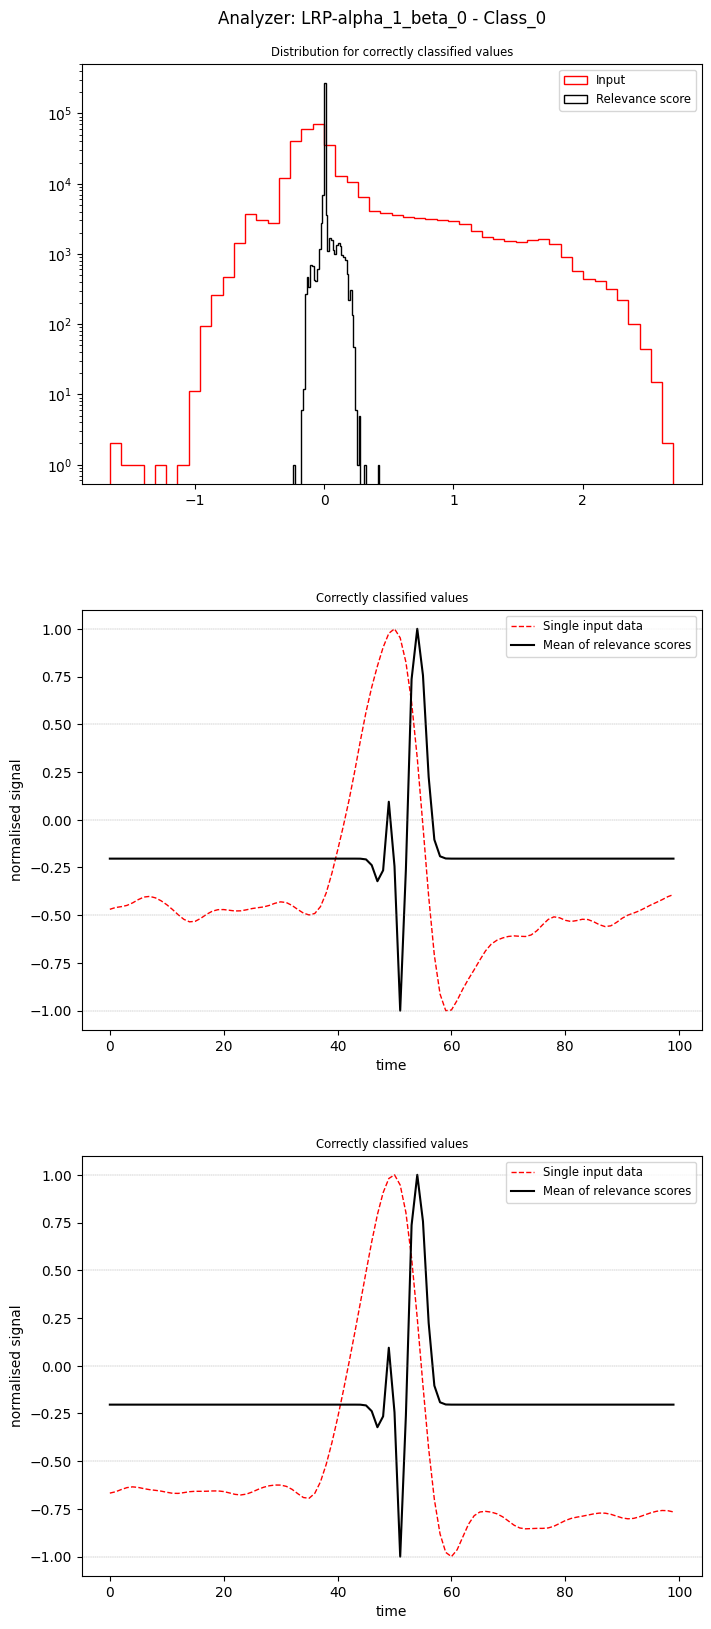

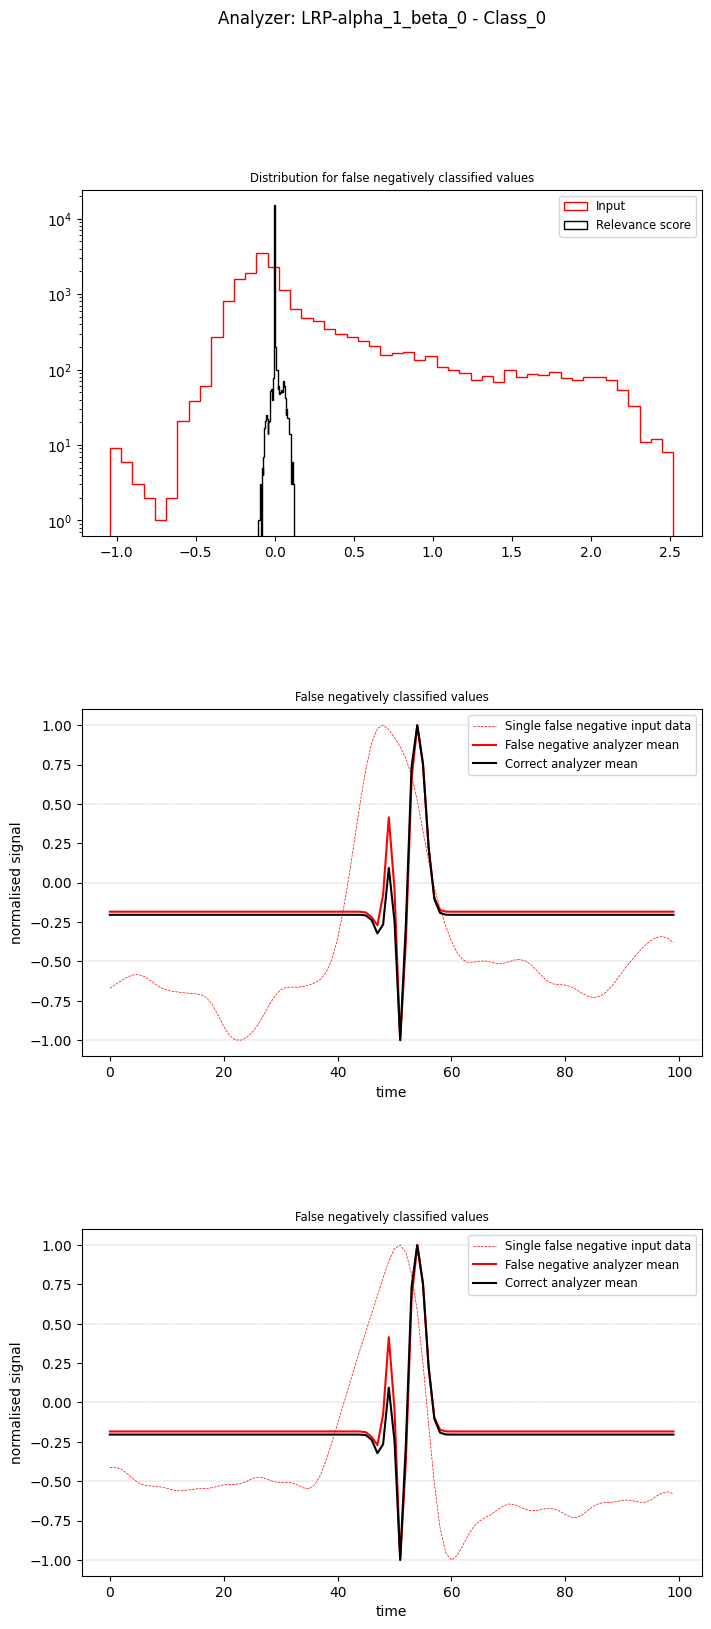

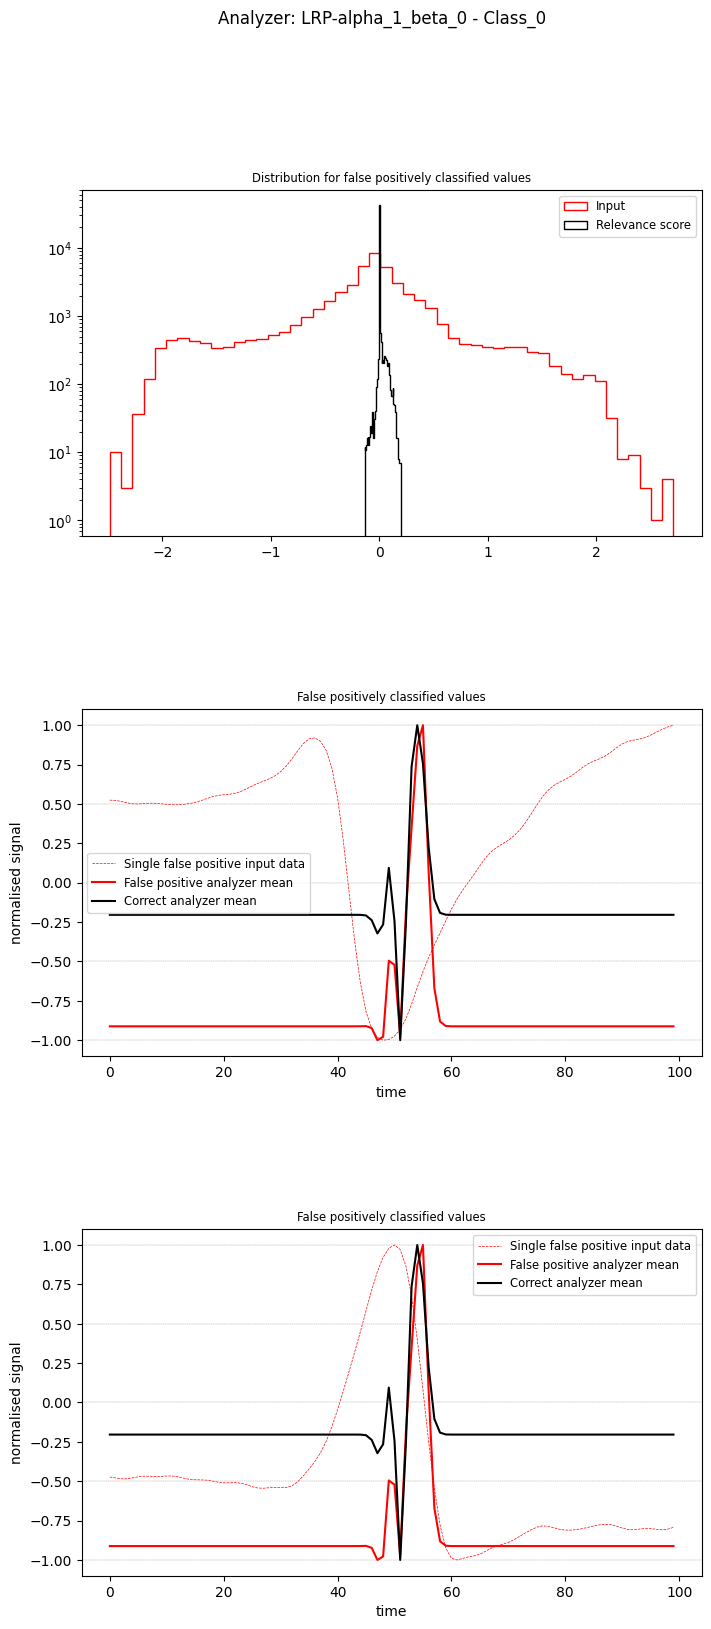

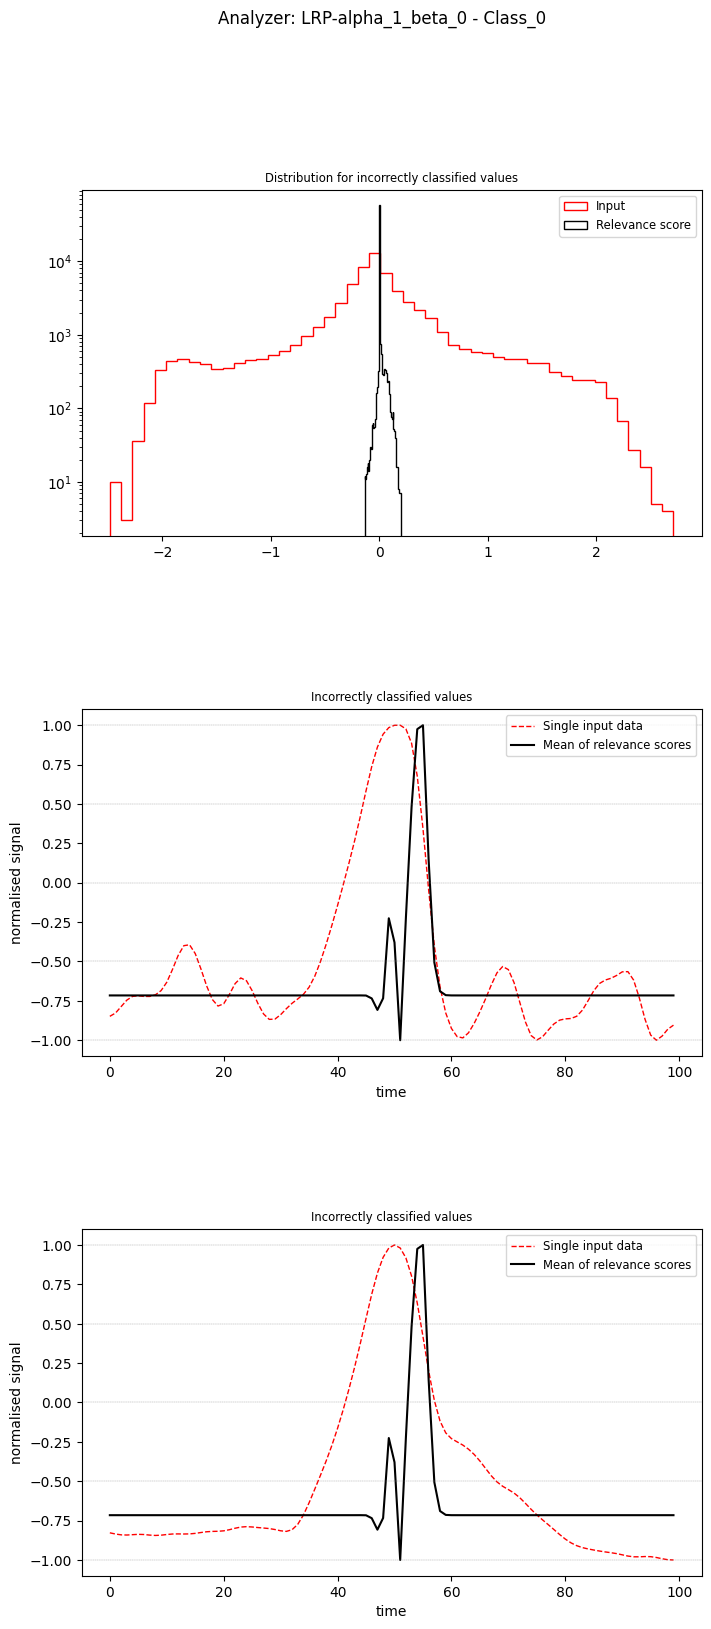

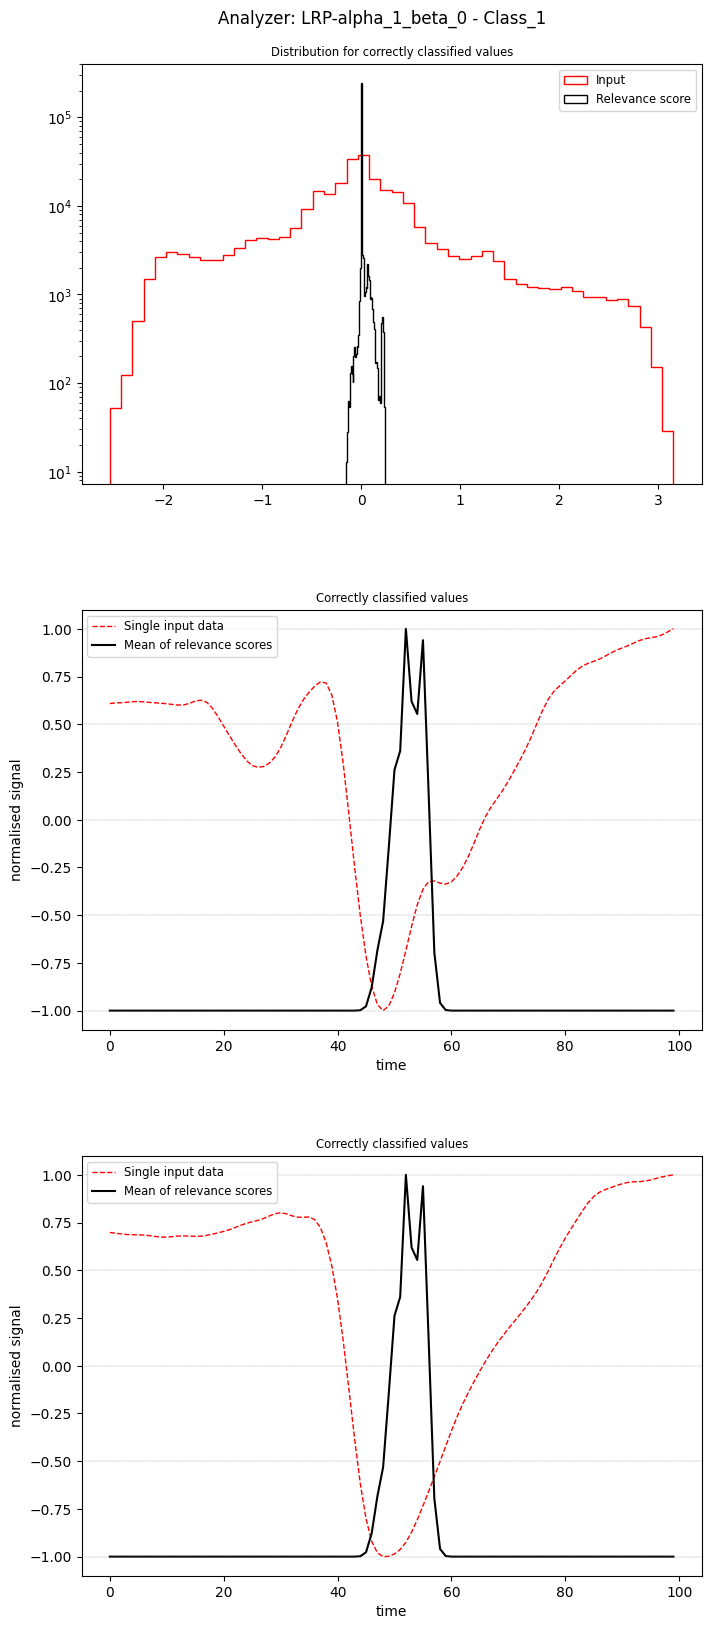

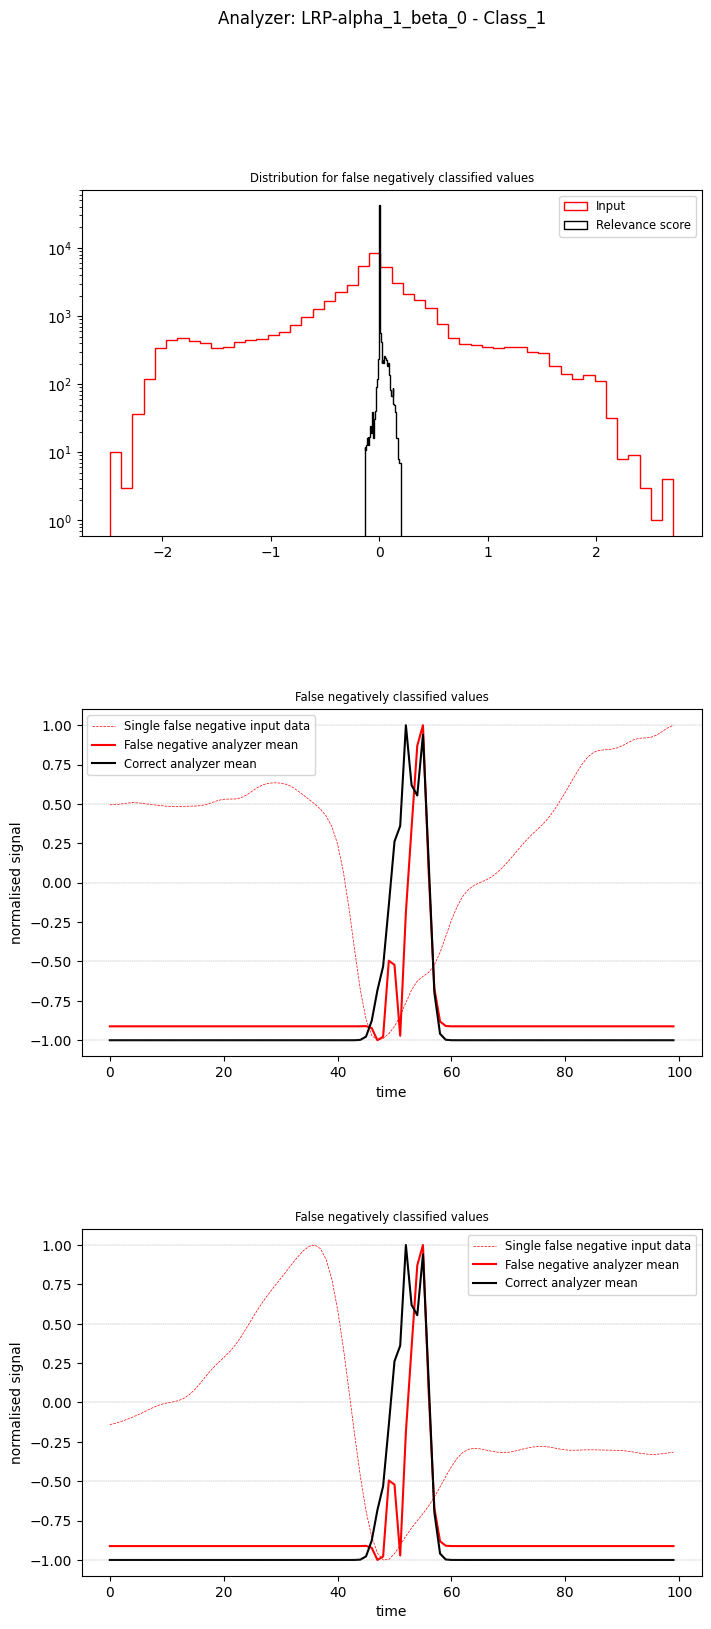

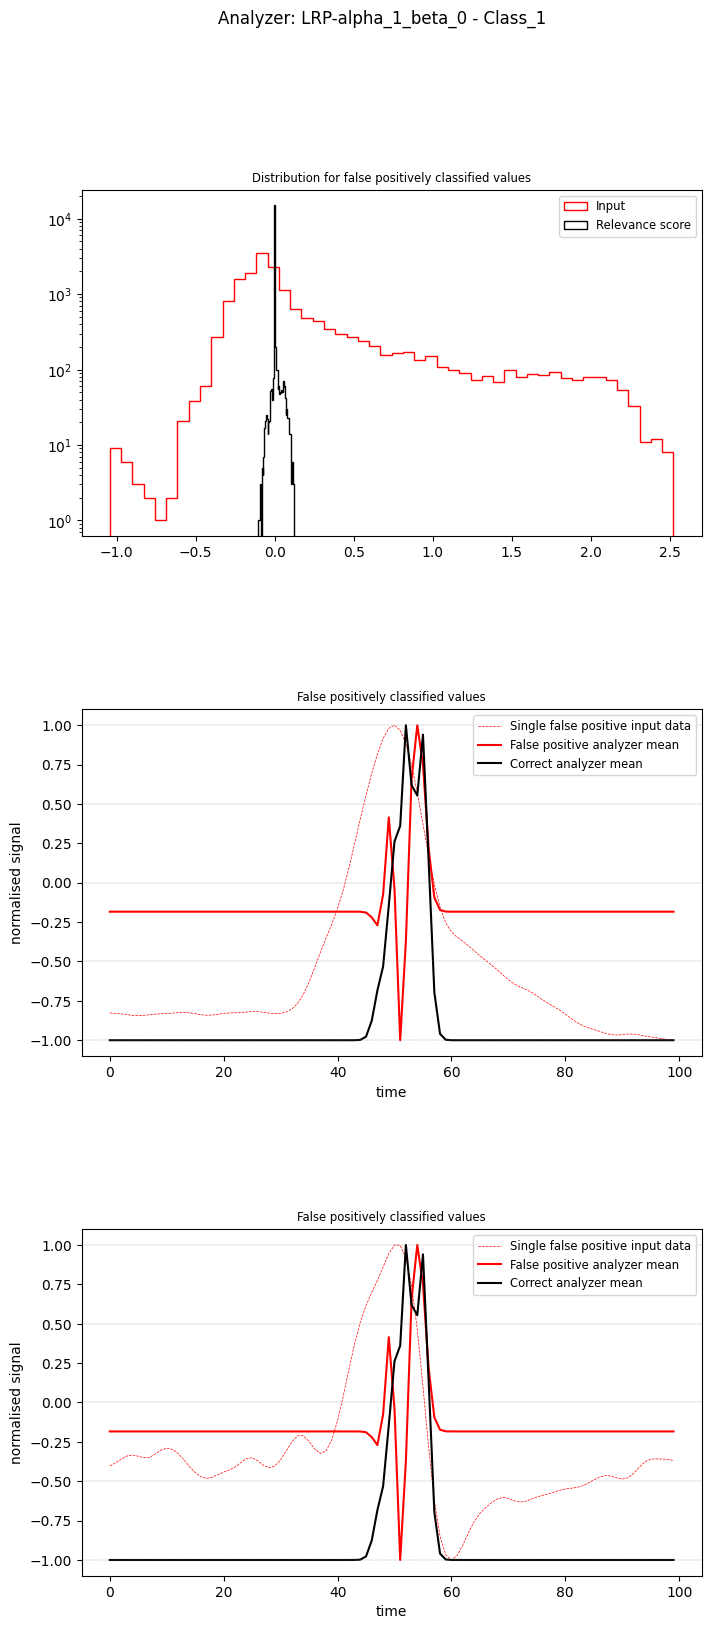

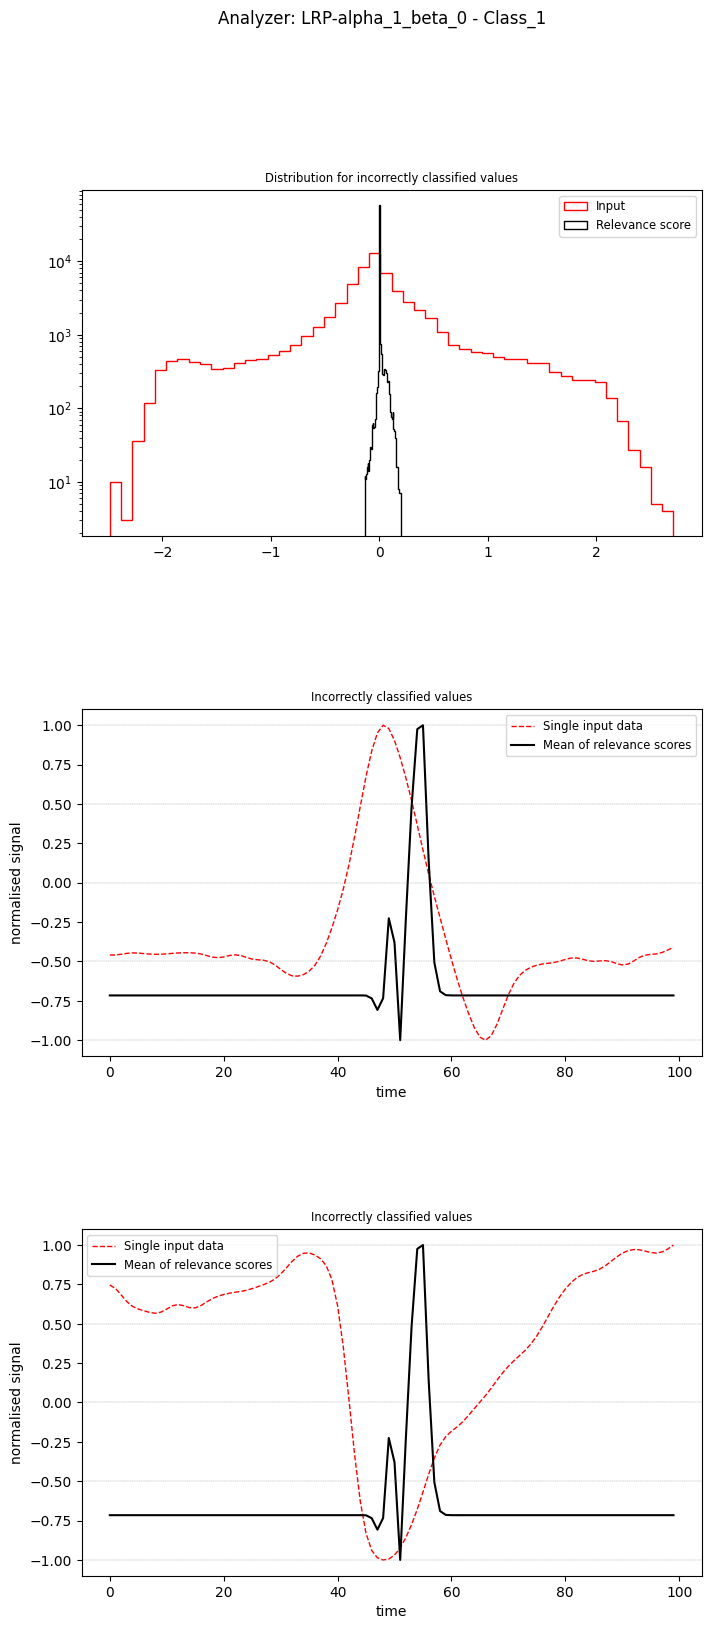

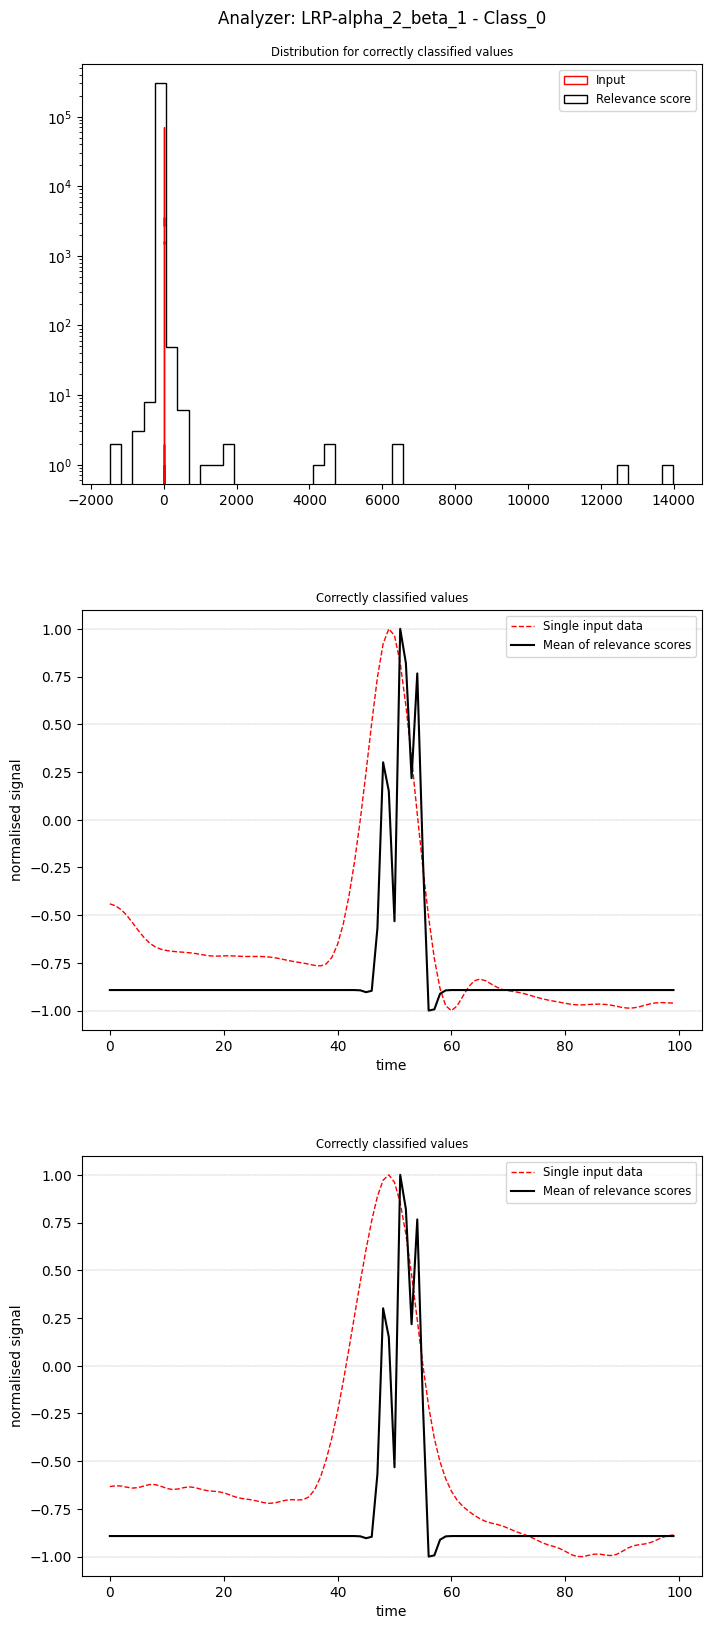

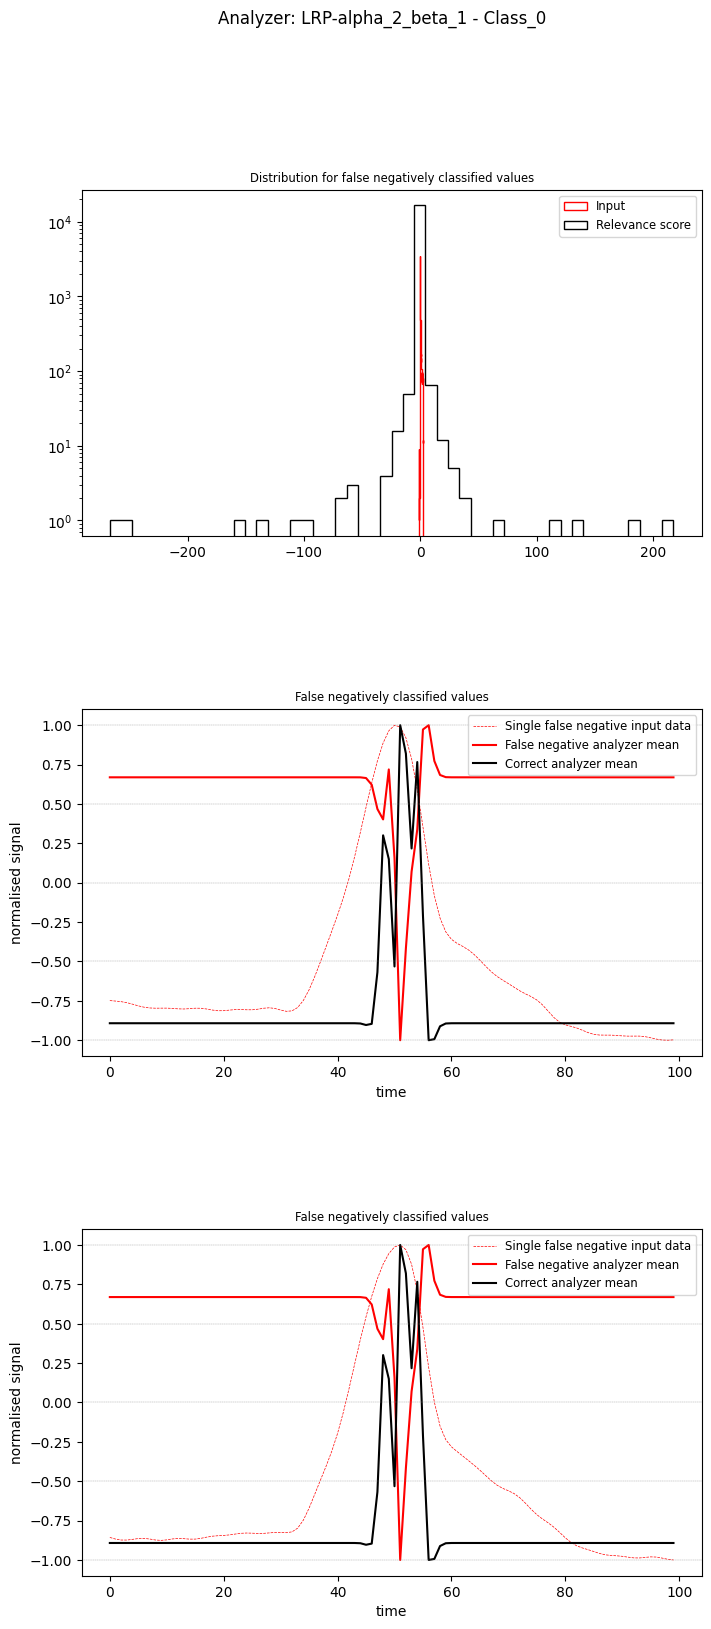

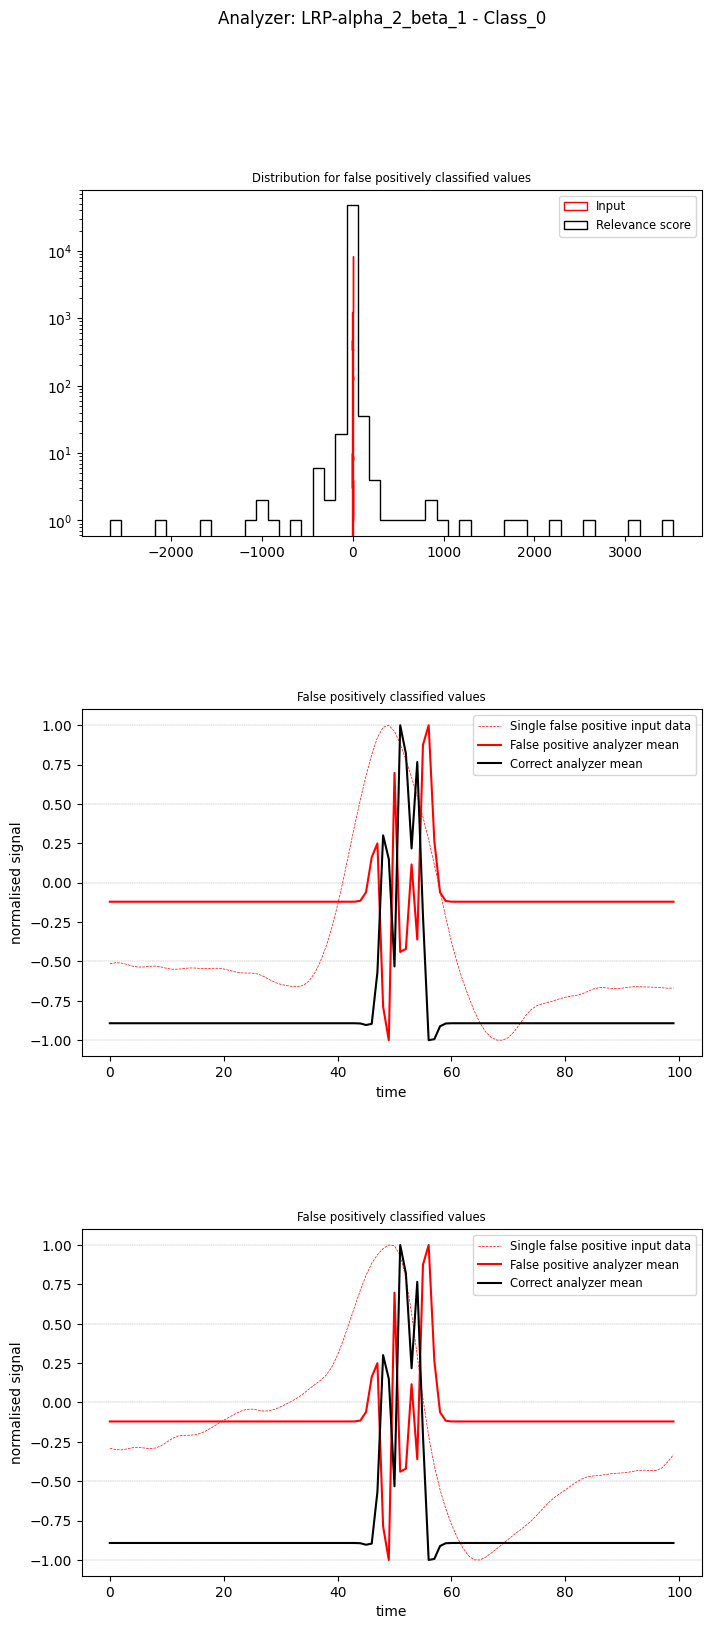

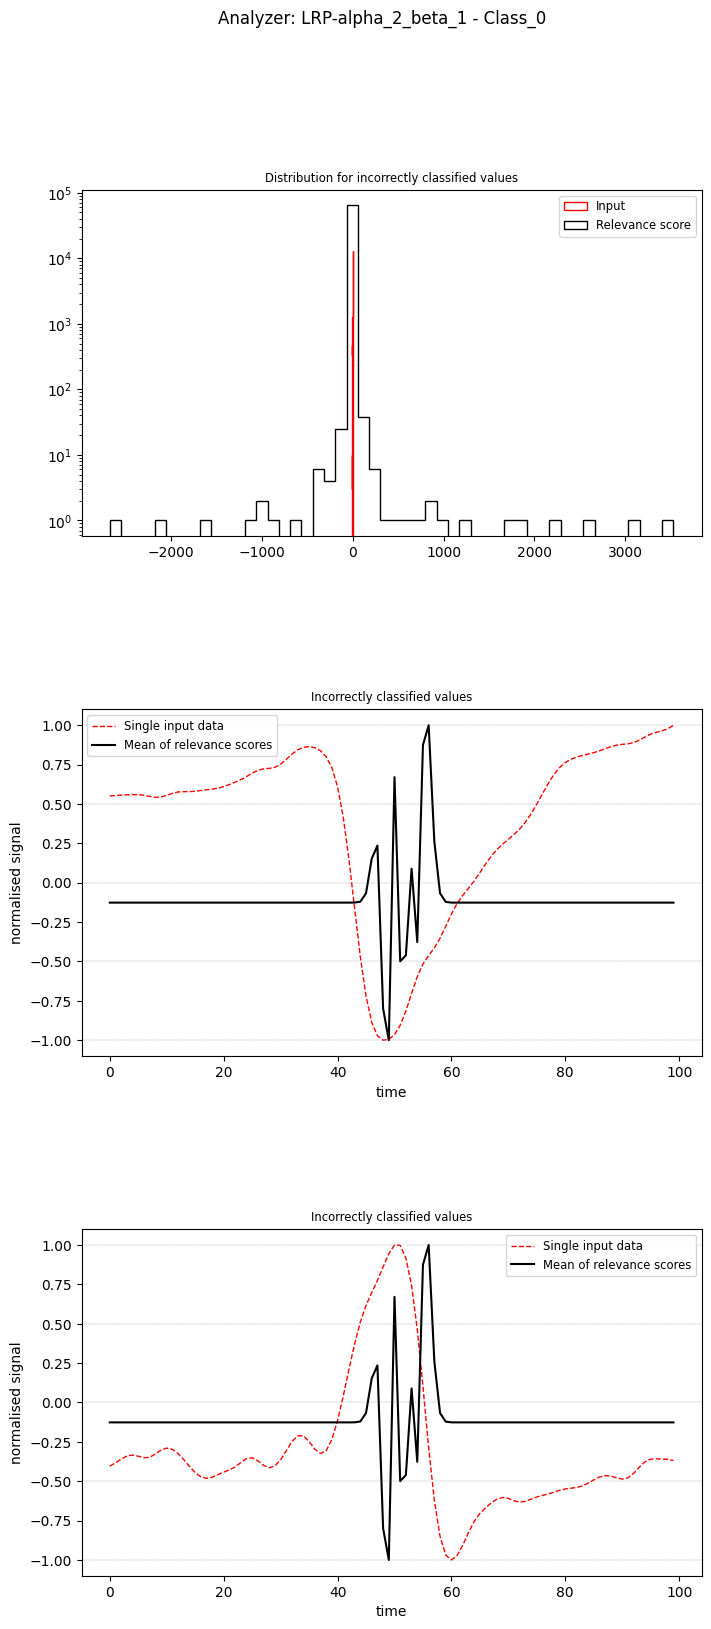

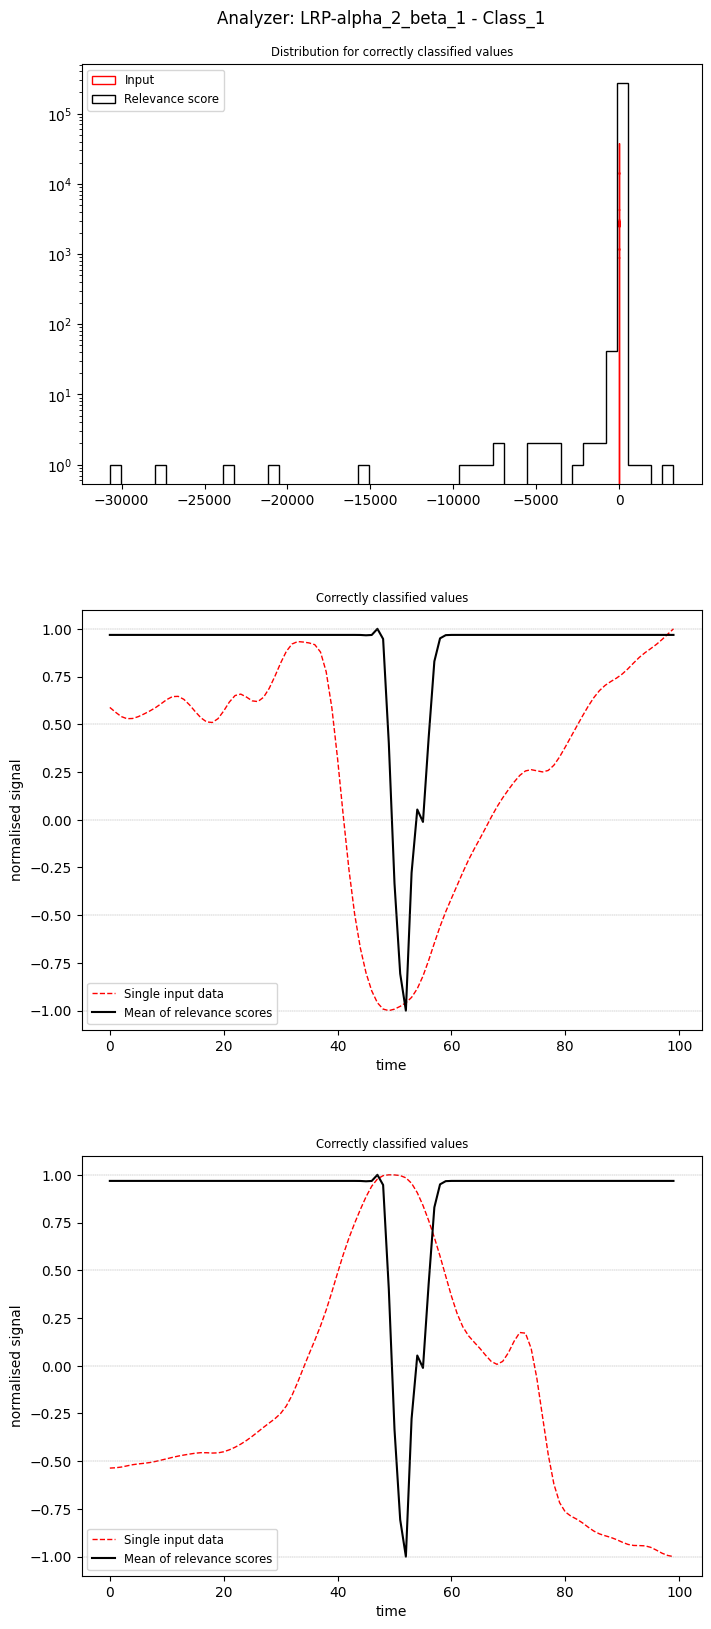

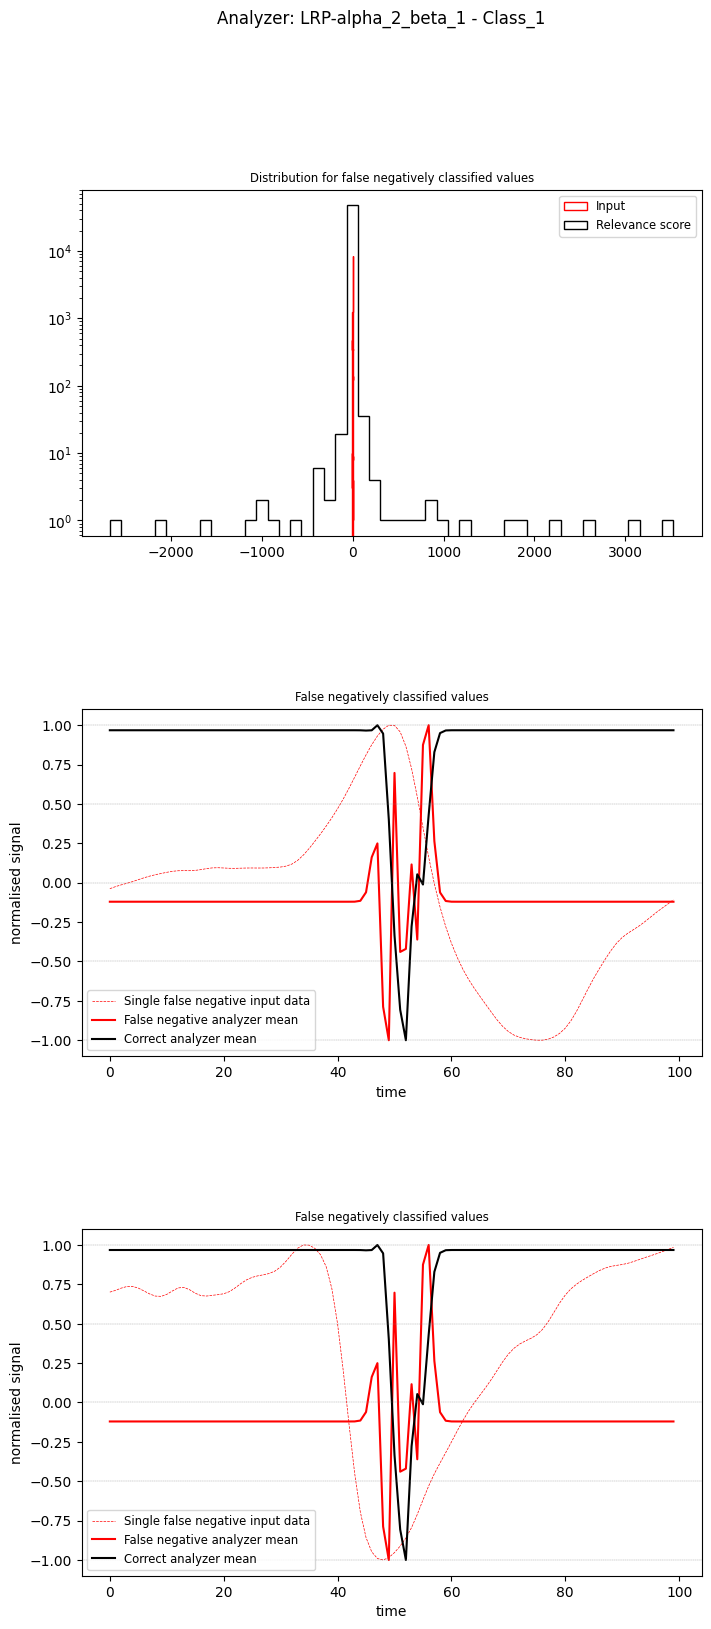

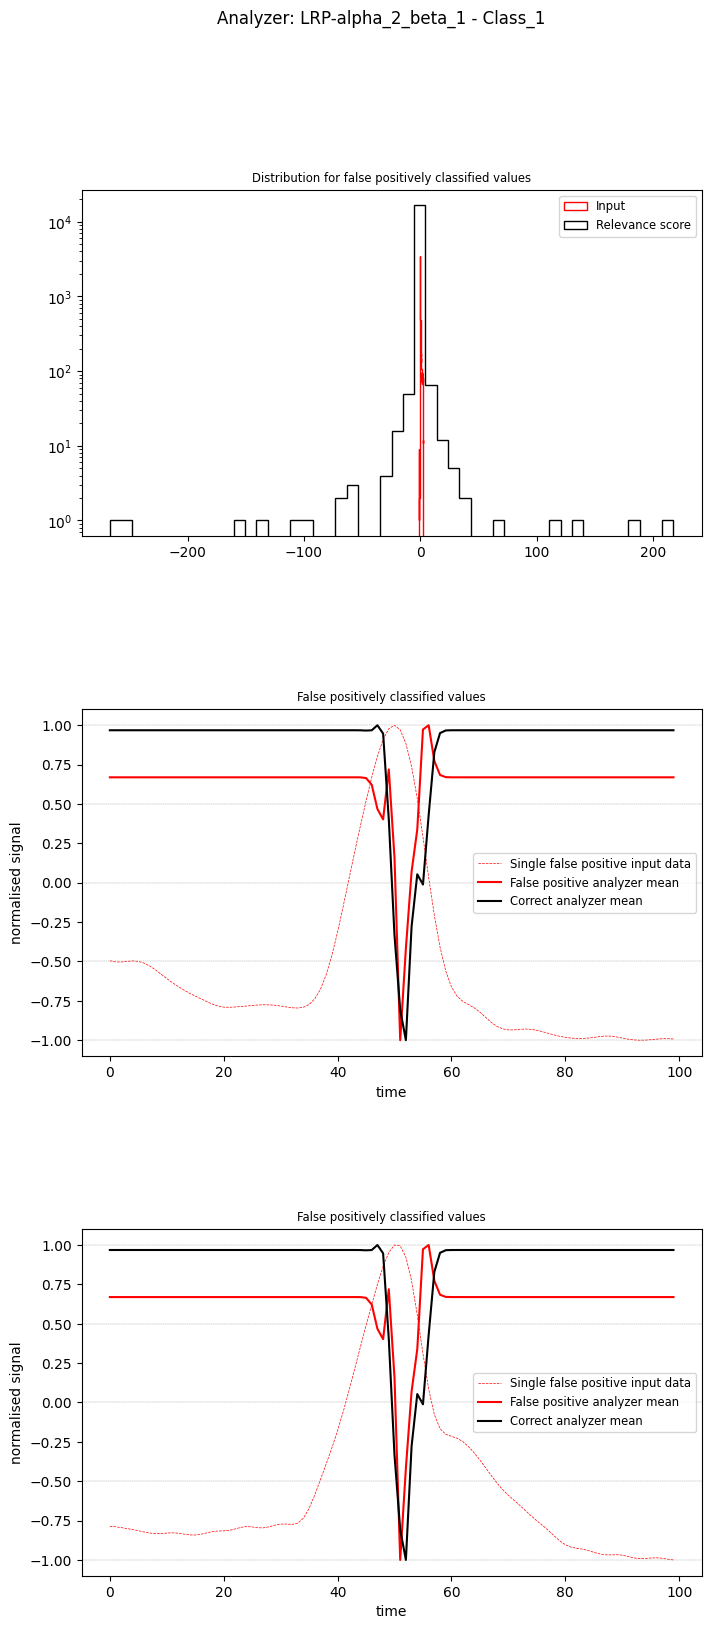

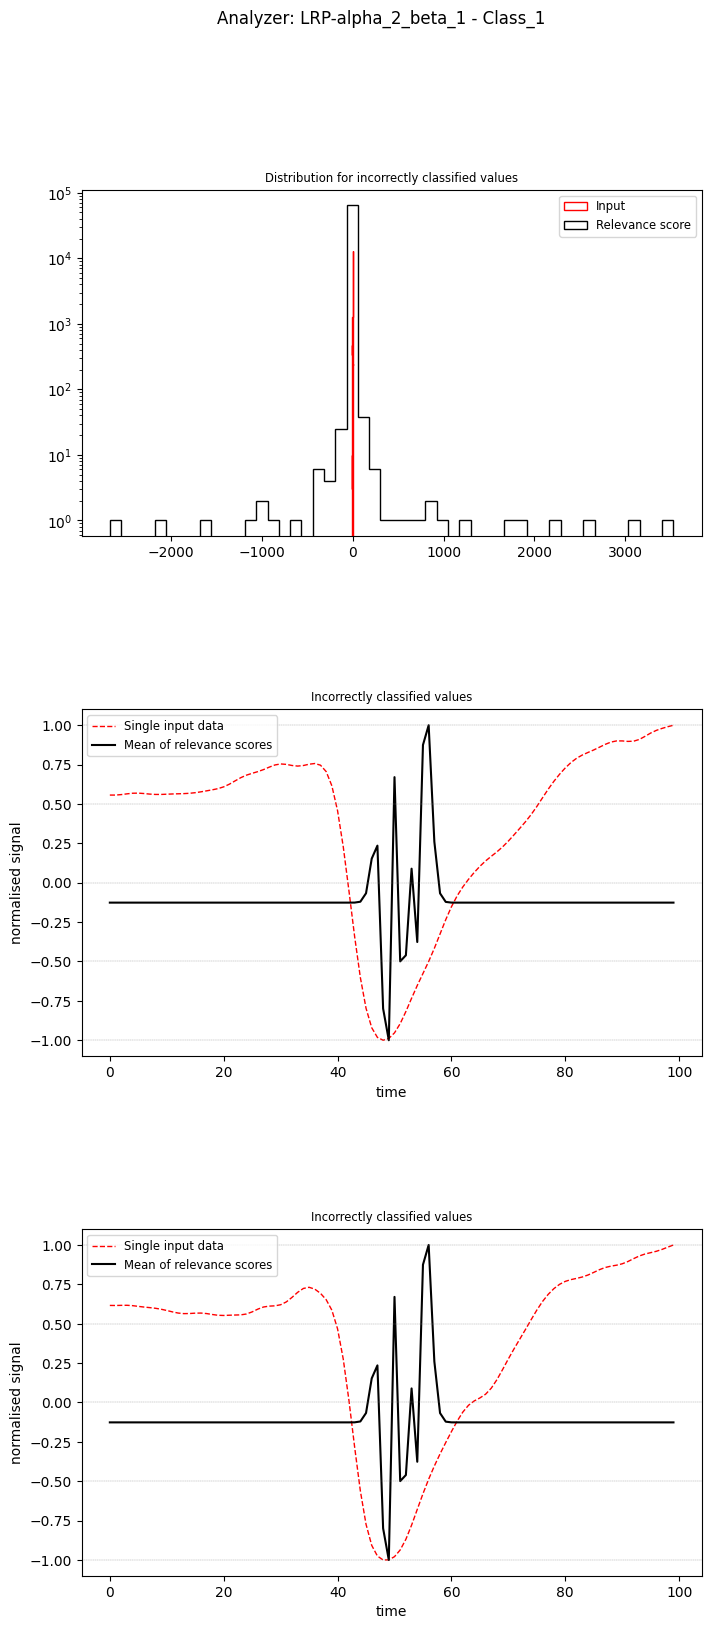

In [68]:
def plot_avg_analyzer_vs_random_beat(input, labels, analyzer, class_num, num_to_analyze, title, predictions):
    """
        Subplots for comparison between single and average signals
        Distinctive for correct, incorrect, false negative and false positive
    """
    analyzer_output = analyzer.analyze(input)
    #class indices based on the labels
    correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, class_num)
    false_neg_indices_for_class = get_false_negative_indices(predictions, labels, class_num)
    false_pos_indices_for_class = get_false_positive_indices(predictions, labels, class_num)
    incorrect_indices_for_class = get_incorrect_prediction_indices_for_class(predictions, labels, class_num)

    #class values compared to the predictions
    correct_input_for_class = input[correct_indices_for_class]
    false_neg_input_for_class = input[false_neg_indices_for_class]
    false_pos_input_for_class = input[false_pos_indices_for_class]
    incorrect_input_for_class = input[incorrect_indices_for_class]

    #analyzer values for class based on the predictions
    correct_analyzer_for_class = analyzer_output[correct_indices_for_class]
    false_neg_analyzer_for_class = analyzer_output[false_neg_indices_for_class]
    false_pos_analyzer_for_class = analyzer_output[false_pos_indices_for_class]
    incorrect_analyzer_for_class = analyzer_output[incorrect_indices_for_class]
    
    if correct_input_for_class.shape[0] == 0:
        print(f"There is no class {class_num}.")
        return

    correct_analyzer_class_mean = np.mean(correct_analyzer_for_class, axis=0, keepdims=True)
    false_neg_analyzer_class_mean = np.mean(false_neg_analyzer_for_class, axis=0, keepdims=True)
    false_pos_analyzer_class_mean = np.mean(false_pos_analyzer_for_class, axis=0, keepdims=True)
    incorrect_analyzer_class_mean = np.mean(incorrect_analyzer_for_class, axis=0, keepdims=True)

    correct_input_class_mean = np.mean(correct_input_for_class, axis=0, keepdims=True)
    incorrect_input_class_mean = np.mean(incorrect_input_for_class, axis=0, keepdims=True)


    random_correct_indices_to_plot = random.sample(range(correct_input_for_class.shape[0]), num_to_analyze)
    random_false_neg_indices_to_plot = random.sample(range(false_neg_input_for_class.shape[0]), num_to_analyze)
    random_false_pos_indices_to_plot = random.sample(range(false_pos_input_for_class.shape[0]), num_to_analyze)
    random_incorrect_indices_to_plot = random.sample(range(incorrect_input_for_class.shape[0]), num_to_analyze)
    classes = ['Class_0', 'Class_1', 'Class_2']

    #########################################################################################
    """
        Distribution, and comparison line plots for CORRECTLY classified signals
    """
    fig, axs = plt.subplots(num_to_analyze + 1, 1, figsize=(8, 6 *(num_to_analyze+1)))
    plt.subplots_adjust(top=0.95, hspace=0.3)


    axs[0].hist(correct_input_for_class.flatten(), bins=50, color="r", histtype='step', linewidth=1, label="Input")
    axs[0].hist(correct_analyzer_for_class.flatten(), bins=50, color = "k", histtype='step', linewidth=1, label="Relevance score")
    axs[0].set_title("Distribution for correctly classified values", fontsize='small')
    axs[0].set_yscale("log")
    axs[0].legend(fontsize = 'small')
    
    for i, index in enumerate(random_correct_indices_to_plot):
        ax = axs[i+1]
        #input
        ax.plot(normalize(correct_input_for_class[index,:], -1, 1), color="r", linestyle = "dashed", linewidth = 1, label="Single input data")
        ax.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Mean of relevance scores")

        for h_line in np.arange(-1,1.25,0.5):
            ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
        ax.set_yticks(np.arange(-1, 1.25, 0.25))
        ax.legend(fontsize = 'small')
        ax.set_ylabel("normalised signal")
        ax.set_xlabel("time")
        ax.set_title("Correctly classified values", fontsize='small')
    fig.suptitle(f"Analyzer: {title} - {classes[class_num]}")
    plt.savefig(f"{Path.cwd()}\..\plots\latest\ecg\\avg_analyzer_single_beat\correct\{title}_class_{class_num}.png")
    plt.show()
    #########################################################################################
    """
        Distribution, and comparison line plots for FALSE NEGATIVELY classified signals
    """
    if len(false_neg_input_for_class) > 0:
        fig, axs = plt.subplots(num_to_analyze + 1, 1, figsize=(8, 6 *(num_to_analyze+1)))
        plt.subplots_adjust(hspace=0.5)
        
        axs[0].hist(false_neg_input_for_class.flatten(), bins=50, color="r", histtype='step', linewidth=1, label="Input")
        axs[0].hist(false_neg_analyzer_for_class.flatten(), bins=50, color = "k", histtype='step', linewidth=1, label="Relevance score")
        axs[0].set_title("Distribution for false negatively classified values", fontsize='small')
        axs[0].set_yscale("log")
        axs[0].legend(fontsize = 'small')
        
        for i, index in enumerate(random_false_neg_indices_to_plot):
            ax = axs[i+1]
            ax.plot(normalize(false_neg_input_for_class[index,:], -1, 1), color="r", linestyle = "dashed", linewidth = 0.5 ,label="Single false negative input data")
            #ax.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Correct input mean")
            ax.plot(normalize(false_neg_analyzer_class_mean[0,:], -1, 1), color="r", linewidth = 1.5, label="False negative analyzer mean")
            ax.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Correct analyzer mean")
            
            for h_line in np.arange(-1,1.25,0.5):
                ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
            
            ax.set_yticks(np.arange(-1, 1.25, 0.25))
            ax.legend(fontsize = 'small')
            ax.set_ylabel("normalised signal")
            ax.set_xlabel("time")
            ax.set_title("False negatively classified values", fontsize='small')
        fig.suptitle(f"Analyzer: {title} - {classes[class_num]}")
        plt.savefig(f"{Path.cwd()}\..\plots\latest\ecg\\avg_analyzer_single_beat\\false_neg\{title}_class_{class_num}.png")
        plt.show()

    #########################################################################################
    """
        Distribution, and comparison line plots for FALSE POSITIVELY classified signals
    """
    if len(false_pos_input_for_class) > 0:
        fig, axs = plt.subplots(num_to_analyze + 1, 1, figsize=(8, 6 *(num_to_analyze+1)))
        plt.subplots_adjust(hspace=0.5)

        axs[0].hist(false_pos_input_for_class.flatten(), bins=50, color="r", histtype='step', linewidth=1, label="Input")
        axs[0].hist(false_pos_analyzer_for_class.flatten(), bins=50, color = "k", histtype='step', linewidth=1, label="Relevance score")
        axs[0].set_title("Distribution for false positively classified values", fontsize='small')
        axs[0].set_yscale("log")
        axs[0].legend(fontsize = 'small')
        
        for i, index in enumerate(random_false_pos_indices_to_plot):
            ax = axs[i+1]
            ax.plot(normalize(false_pos_input_for_class[index,:], -1, 1), color="r", linestyle = "dashed", linewidth = 0.5, label="Single false positive input data")
            #ax.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Correct input mean")
            ax.plot(normalize(false_pos_analyzer_class_mean[0,:], -1, 1), color="r", linewidth = 1.5, label="False positive analyzer mean")
            ax.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Correct analyzer mean")
            
            for h_line in np.arange(-1,1.25,0.5):
                ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
            
            ax.set_yticks(np.arange(-1, 1.25, 0.25))
            ax.legend(fontsize = 'small')
            ax.set_ylabel("normalised signal")
            ax.set_xlabel("time")
            ax.set_title("False positively classified values", fontsize='small')
        fig.suptitle(f"Analyzer: {title} - {classes[class_num]}")
        plt.savefig(f"{Path.cwd()}\..\plots\latest\ecg\\avg_analyzer_single_beat\\false_pos\{title}_class_{class_num}.png")
        plt.show()
    #########################################################################################
    """
        Distribution, and comparison line plots for INCORRECTLY classified signals
    """
    fig, axs = plt.subplots(num_to_analyze + 1, 1, figsize=(8, 6 *(num_to_analyze+1)))
    plt.subplots_adjust(hspace=0.5)

    axs[0].hist(incorrect_input_for_class.flatten(), bins=50, color="r", histtype='step', linewidth=1, label="Input")
    axs[0].hist(incorrect_analyzer_for_class.flatten(), bins=50, color = "k", histtype='step', linewidth=1, label="Relevance score")
    axs[0].set_title("Distribution for incorrectly classified values", fontsize='small')
    axs[0].set_yscale("log")
    axs[0].legend(fontsize = 'small')
    
    for i, index in enumerate(random_incorrect_indices_to_plot):
        ax = axs[i+1]
        #input
        ax.plot(normalize(incorrect_input_for_class[index,:], -1, 1), color="r", linestyle = "dashed", linewidth = 1, label="Single input data")
        #output
        ax.plot(normalize(incorrect_analyzer_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Mean of relevance scores")
            
        for h_line in np.arange(-1,1.25,0.5):
            ax.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
        
        ax.set_yticks(np.arange(-1, 1.25, 0.25))
        ax.legend(fontsize = 'small')
        ax.set_ylabel("normalised signal")
        ax.set_xlabel("time")
        ax.set_title("Incorrectly classified values", fontsize='small')
    fig.suptitle(f"Analyzer: {title} - {classes[class_num]}")
    plt.savefig(f"{Path.cwd()}\..\plots\latest\ecg\\avg_analyzer_single_beat\incorrect\{title}_class_{class_num}.png")
    plt.show()

for key,value in analyzers.items():
    for class_num in [0,1]:
        plot_avg_analyzer_vs_random_beat(test_x, test_y, value, class_num, 2, key, predictions)

In [8]:

def plot_avarage_relevance_scores_over_class_and_beats(input, labels, analyzer, class_num, title, predictions):
    analyzer_output = analyzer.analyze(input)

    #class indices based on the labels
    correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, class_num)
    false_neg_indices_for_class = get_false_negative_indices(predictions, labels, class_num)
    false_pos_indices_for_class = get_false_positive_indices(predictions, labels, class_num)
    incorrect_indices_for_class = get_incorrect_prediction_indices_for_class(predictions, labels, class_num)

    #class values compared to the predictions
    correct_input_for_class = input[correct_indices_for_class]
    false_neg_input_for_class = input[false_neg_indices_for_class]
    false_pos_input_for_class = input[false_pos_indices_for_class]
    incorrect_input_for_class = input[incorrect_indices_for_class]

    #analyzer values for class based on the predictions
    correct_analyzer_for_class = analyzer_output[correct_indices_for_class]
    false_neg_analyzer_for_class = analyzer_output[false_neg_indices_for_class]
    false_pos_analyzer_for_class = analyzer_output[false_pos_indices_for_class]
    incorrect_analyzer_for_class = analyzer_output[incorrect_indices_for_class]
    classes = ['Class_0', 'Class_1', 'Class_2']
    
    if correct_input_for_class.shape[0] == 0:
        print(f"There is no class {class_num}.")
        return

    correct_analyzer_class_mean = np.mean(correct_analyzer_for_class, axis=0, keepdims=True)
    false_neg_analyzer_class_mean = np.mean(false_neg_analyzer_for_class, axis=0, keepdims=True)
    false_pos_analyzer_class_mean = np.mean(false_pos_analyzer_for_class, axis=0, keepdims=True)
    incorrect_analyzer_class_mean = np.mean(incorrect_analyzer_for_class, axis=0, keepdims=True)

    correct_input_class_mean = np.mean(correct_input_for_class, axis=0, keepdims=True)
    false_neg_input_class_mean = np.mean(false_neg_input_for_class, axis=0, keepdims=True)
    print(false_neg_input_class_mean.shape)
    false_pos_input_class_mean = np.mean(false_pos_input_for_class, axis=0, keepdims=True)
    incorrect_input_class_mean = np.mean(incorrect_input_for_class, axis=0, keepdims=True)

    upsamled_correct_analyzer_for_class = upsample(correct_analyzer_class_mean[0,:], 5)
    upsamled_incorrect_analyzer_for_class = upsample(incorrect_analyzer_class_mean[0,:], 5)

    #########################################################################################
    """
        Correctly classified values
    """

    plt.figure(figsize=(10,6))
    plt.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="r", label="Input mean")
    plt.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Relevance score mean")
    #mean output
    #plt.plot(normalize(correct_analyzer_for_class[0,:], -1, 1), color="k", label="Analyzer mean", linewidth=0.5)
    #plt.scatter(range(len(correct_analyzer_for_class[0,:])), normalize(correct_analyzer_for_class[0,:], -1, 1), color="k", label="Correct analyzer mean", s=2)
    

    for h_line in np.arange(-1,1.25,0.5):
        plt.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
    
    plt.yticks(np.arange(-1, 1.25, 0.25))
    plt.legend(fontsize = 'small')
    plt.ylabel("ecg")
    plt.xlabel("time")
    plt.title(f"Correctly classified values for {title} - Class: {classes[class_num]}")
    plt.savefig(f"{Path.cwd()}\..\plots\latest\ecg\\avg_analyzer_avg_beat\correct\{title}_class_{class_num}.png")
    plt.show()


    #########################################################################################
    """
        False postitive
    """
    if len(false_pos_input_for_class) > 0:
        plt.figure(figsize=(10,6))
        plt.plot(normalize(false_pos_input_class_mean[0,:], -1, 1), color="r", linewidth = 1.5, label="False positive input data mean")
        #plt.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Correct input mean")
        plt.plot(normalize(false_pos_analyzer_class_mean[0,:], -1, 1), color="r", linestyle = "dashed", linewidth = 0.5, label="False positive analyzer mean")
        plt.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct analyzer mean")
        for h_line in np.arange(-1,1.25,0.5):
            plt.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
        plt.yticks(np.arange(-1, 1.25, 0.25))
        plt.legend(fontsize = 'small')
        plt.ylabel("ecg")
        plt.xlabel("time")
        plt.title(f"False positively classified values for {title} - Class: {class_num}")
        plt.savefig(f"{Path.cwd()}\..\plots\latest\ecg\\avg_analyzer_avg_beat\\false_pos\{title}_class_{class_num}.png")
        plt.show()

    #########################################################################################
    """
        False negative
    """
    if len(false_neg_input_for_class) > 0:
        plt.figure(figsize=(10,6))
        plt.plot(normalize(false_neg_input_class_mean[0,:], -1, 1), color="r", linewidth = 1.5, label="False negative input data mean")
        #plt.plot(normalize(correct_input_class_mean[0,:], -1, 1), color="k", linewidth = 1.5, label="Correct input mean")
        plt.plot(normalize(false_neg_analyzer_class_mean[0,:], -1, 1), color="r", linestyle = "dashed", linewidth = 0.5, label="False negative relevance score mean")
        plt.plot(normalize(correct_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Correct relevance score mean")
        #plt.scatter(range(len(incorrect_analyzer_for_class[0,:])), normalize(correct_analyzer_for_class[0,:], -1, 1), color="k", label="Analyzer mean", s=2)
        for h_line in np.arange(-1,1.25,0.5):
            plt.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
        plt.yticks(np.arange(-1, 1.25, 0.25))
        plt.legend(fontsize = 'small')
        plt.ylabel("ecg")
        plt.xlabel("time")
        plt.title(f"False negatively classified values for {title} - Class: {class_num}")
        plt.savefig(f"{Path.cwd()}\..\plots\latest\ecg\\avg_analyzer_avg_beat\\false_neg\{title}_class_{class_num}.png")
        plt.show()
    #########################################################################################
    """
        Incorrectly classified values
    """

    plt.figure(figsize=(10,6))
    plt.plot(normalize(incorrect_input_class_mean[0,:], -1, 1), color="r", label="Input mean")
    plt.plot(normalize(incorrect_analyzer_class_mean[0,:], -1, 1), color="k", linestyle = "dashed", linewidth = 0.5, label="Relevance score mean")
    #mean output
    #plt.plot(normalize(correct_analyzer_for_class[0,:], -1, 1), color="k", label="Analyzer mean", linewidth=0.5)
    #plt.scatter(range(len(correct_analyzer_for_class[0,:])), normalize(correct_analyzer_for_class[0,:], -1, 1), color="k", label="Correct analyzer mean", s=2)
    

    for h_line in np.arange(-1,1.25,0.5):
        plt.axhline(y = h_line, color = "gray", linestyle = "dashed", linewidth = 0.25)
    
    plt.yticks(np.arange(-1, 1.25, 0.25))
    plt.legend(fontsize = 'small')
    plt.ylabel("ecg")
    plt.xlabel("time")
    plt.title(f"Inorrectly classified values for {title} - Class: {classes[class_num]}")
    plt.savefig(f"{Path.cwd()}\..\plots\latest\ecg\\avg_analyzer_avg_beat\incorrect\{title}_class_{class_num}.png")
    plt.show()


for key,value in analyzers.items():
    for class_num in [0,1]:
        plot_avarage_relevance_scores_over_class_and_beats(test_x, test_y, value, class_num, key, predictions)




c:\Users\dominika\anaconda3\envs\innvestigate\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(1, 40)


NameError: name 'upsample' is not defined

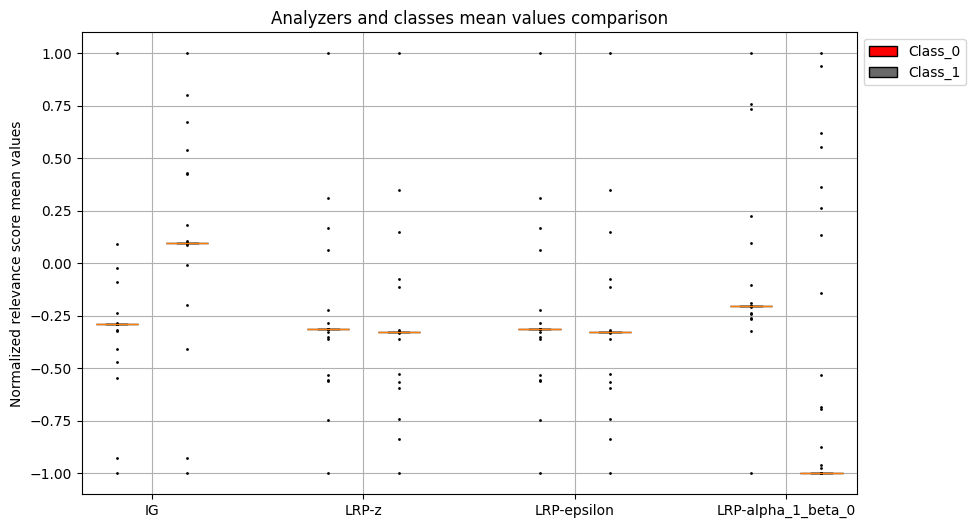

In [75]:
from matplotlib.patches import Patch
def plot_mean_of_relevance_scores(input, labels):
    class_0_to_mean = []
    class_1_to_mean = []
    class_2_to_mean = []
    analyzers = {
    "IG" :integrated_gradient_analyzer,
    "LRP-z": lrp_analyzer,
    "LRP-epsilon" : lrp_epsilon_analyzer,
    "LRP-alpha_1_beta_0": lrp_alpha1_beta0_analyzer
    }
    for name,analyzer in analyzers.items():
        analyzer_output = analyzer.analyze(input)
        correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, 0)
        correct_analyzer_for_class = analyzer_output[correct_indices_for_class]
        correct_analyzer_class_mean = np.mean(correct_analyzer_for_class, axis=0, keepdims=True)
        class_0_to_mean.append(normalize(correct_analyzer_class_mean.flatten(),-1,1))

        correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, 1)
        correct_analyzer_for_class = analyzer_output[correct_indices_for_class]
        correct_analyzer_class_mean = np.mean(correct_analyzer_for_class, axis=0, keepdims=True)
        class_1_to_mean.append(normalize(correct_analyzer_class_mean.flatten(),-1,1))


    # Create a list of labels for the analyzers
    plt.figure(figsize=(10, 6))
    flierprops = dict(marker='o', markersize=1, linestyle='none')
    plt.boxplot(class_0_to_mean,positions = [1,4,7,10], flierprops = flierprops,  widths=0.6, patch_artist=True, boxprops=dict(facecolor='red'))
    plt.boxplot(class_1_to_mean,positions = [2,5,8,11], flierprops = flierprops, widths=0.6, patch_artist=True, boxprops=dict(facecolor='dimgray'))
    plt.xticks([1.5, 4.5, 7.5, 10.5], analyzers.keys())
    """
    # Create the boxplot
    positions = np.arange(len(analyzers_labels)) * 2
    for i in range(len(analyzers_labels)):
        plt.boxplot(class_0_to_mean[i],positions=positions, widths=0.6, patch_artist=True)
        plt.boxplot(class_1_to_mean[i],positions=positions, widths=0.6, patch_artist=True) 
        #plt.xticks(np.arange(len(analyzers_labels)) * 2, analyzers_labels)
        positions += len(analyzers_labels) * 2
    """
    # Add labels and title
    plt.ylabel('Normalized relevance score mean values')
    plt.title('Analyzers and classes mean values comparison')

    # Add legend
    legend_patches = [Patch(facecolor='red', edgecolor='black', label='Class_0'),
                  Patch(facecolor='dimgray', edgecolor='black', label='Class_1')]

    plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.grid(True)
    plt.savefig(f"{Path.cwd()}\..\plots\latest\ecg\\analyzers_and_classes2.png")
    plt.show() 

plot_mean_of_relevance_scores(test_x, test_y)

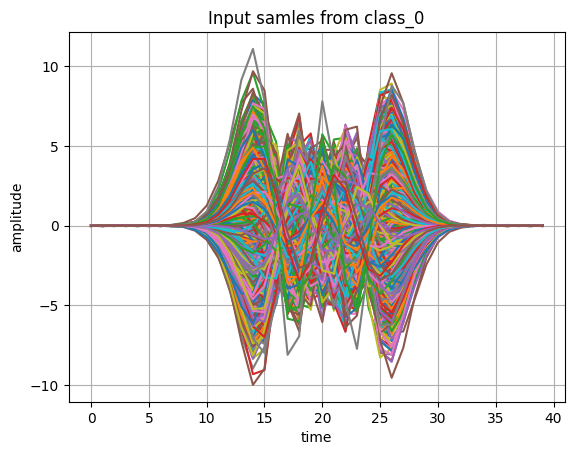

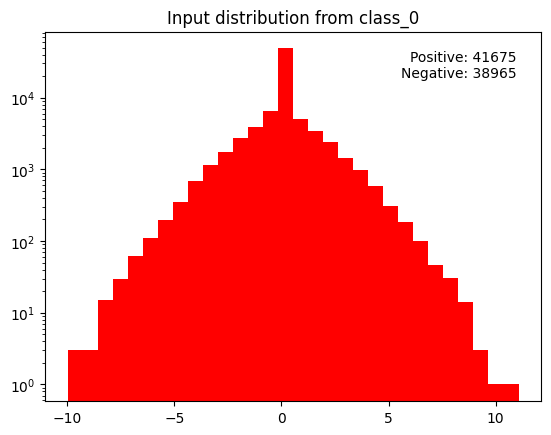

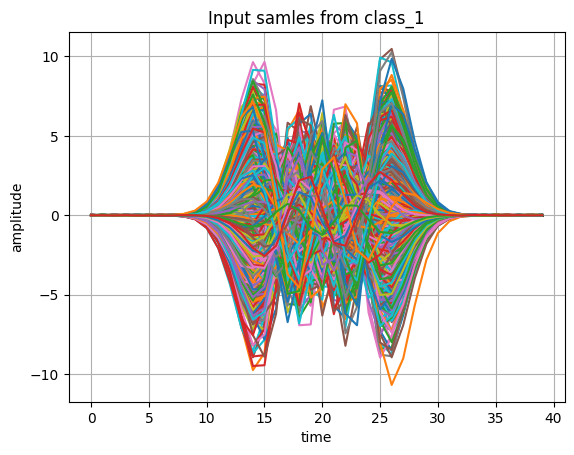

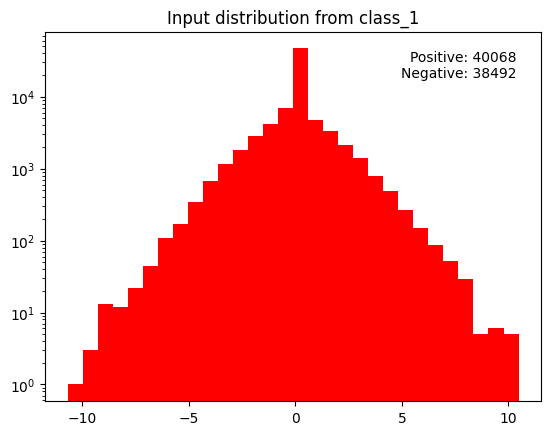

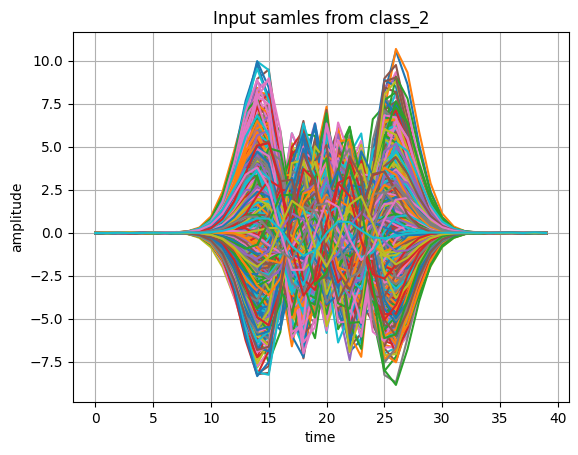

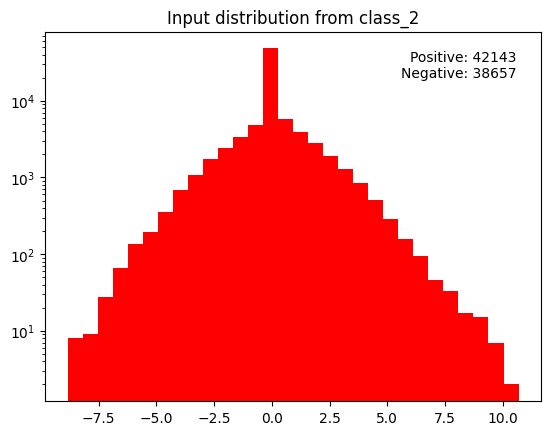

In [34]:
def visualize_input_class(input, labels,class_num):
    indices = get_truth_class_indices(class_num, labels)
    rows_to_plot = input[indices]

    # Create a matplotlib figure
    plt.figure()

    # Plot each row as a separate line
    for row in rows_to_plot:
        plt.plot(row)

    # Add title and labels
    plt.title(f'Input samles from class_{class_num}')
    plt.xlabel('time')
    plt.ylabel('amplitude')

    # Display the plot
    plt.grid(True)
    plt.show()

    data = rows_to_plot.flatten()
    plt.figure()
    positive_count = np.sum(data > 0)
    negative_count = np.sum(data < 0)
    label = f"Positive: {positive_count}\nNegative: {negative_count}"

    # Plot each row as a separate line
    plt.hist(data, bins = 30, color='red')
    plt.yscale("log")

    # Add title and labels
    plt.title(f'Input distribution from class_{class_num}')
    plt.text(0.95, 0.95, label, ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

    # Display the plot
    plt.show()
visualize_input_class(test_x, test_y, 0)
visualize_input_class(test_x, test_y, 1)
visualize_input_class(test_x, test_y, 2)


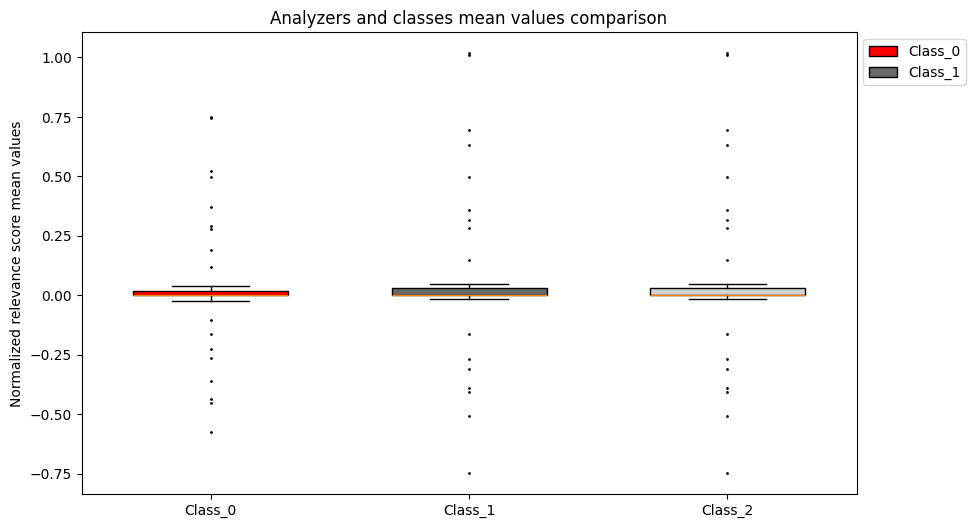

In [44]:
from matplotlib.patches import Patch
def plot_mean_of_relevance_scores(input, labels):
    class_0_to_mean = []
    class_1_to_mean = []
    class_2_to_mean = []

    correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, 0)
    correct_input_for_class = input[correct_indices_for_class]
    correct_input_class_mean = np.mean(correct_input_for_class, axis=0, keepdims=True)
    class_0_to_mean.append(normalize(correct_input_class_mean.flatten(),-1,1))

    correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, 1)
    correct_input_for_class = input[correct_indices_for_class]
    correct_input_class_mean = np.mean(correct_input_for_class, axis=0, keepdims=True)
    class_1_to_mean.append(normalize(correct_input_class_mean.flatten(),-1,1))

    correct_indices_for_class = get_correct_prediction_indices_for_class(predictions, labels, 2)
    correct_input_for_class = input[correct_indices_for_class]
    correct_input_class_mean = np.mean(correct_input_for_class, axis=0, keepdims=True)
    class_2_to_mean.append(normalize(correct_input_class_mean.flatten(),-1,1))



    # Create a list of labels for the analyzers
    plt.figure(figsize=(10, 6))
    flierprops = dict(marker='o', markersize=1, linestyle='none')
    plt.boxplot(class_0_to_mean,positions = [1], flierprops = flierprops,  widths=0.6, patch_artist=True, boxprops=dict(facecolor='red'))
    plt.boxplot(class_1_to_mean,positions = [2], flierprops = flierprops, widths=0.6, patch_artist=True, boxprops=dict(facecolor='dimgray'))
    plt.boxplot(class_1_to_mean,positions = [3], flierprops = flierprops, widths=0.6, patch_artist=True, boxprops=dict(facecolor='lightgray'))
    plt.xticks([1,2,3], ['Class_0', 'Class_1', 'Class_2'])
    """
    # Create the boxplot
    positions = np.arange(len(analyzers_labels)) * 2
    for i in range(len(analyzers_labels)):
        plt.boxplot(class_0_to_mean[i],positions=positions, widths=0.6, patch_artist=True)
        plt.boxplot(class_1_to_mean[i],positions=positions, widths=0.6, patch_artist=True) 
        #plt.xticks(np.arange(len(analyzers_labels)) * 2, analyzers_labels)
        positions += len(analyzers_labels) * 2
    """
    # Add labels and title
    plt.ylabel('Normalized relevance score mean values')
    plt.title('Analyzers and classes mean values comparison')

    # Add legend
    legend_patches = [Patch(facecolor='red', edgecolor='black', label='Class_0'),
                  Patch(facecolor='dimgray', edgecolor='black', label='Class_1')]

    plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    #plt.savefig(f"{Path.cwd()}\..\plots\latest\ecg\\analyzers_and_classes2.png")
    plt.show() 

plot_mean_of_relevance_scores(test_x, test_y)